In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
import findspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window


In [2]:
findspark.init()
spark= SparkSession.builder.getOrCreate()


In [3]:
spark

In [4]:
prize = spark.read.csv('dota_prizes.csv',inferSchema=True,header=True)

In [5]:
prize.show(5)

+--------------------+-----+-------------+------+
|          Tournament|Place|         Team| Prize|
+--------------------+-----+-------------+------+
|The Chongqing Maj...|    1|  Team Secret|350000|
|The Chongqing Maj...|    2|   Virtus.pro|170000|
|The Chongqing Maj...|    3|Evil Geniuses|100000|
|The Chongqing Maj...|    4|      PSG.LGD| 80000|
|The Chongqing Maj...|    5|        EHOME| 60000|
+--------------------+-----+-------------+------+
only showing top 5 rows



In [6]:
tour=spark.read.csv('dota_tournament.csv',inferSchema=True,header=True)
tour.show(5)

+-------+--------+---+--------------------+----------+-------+-----+------+--------+-----------------+-----------------+----------------+-------------------+-----------+
|     ID|MATCH_ID|MAP|          TOURNAMENT|      TEAM|   SIDE|SCORE|RESULT|DURATION|           HERO_1|           HERO_2|          HERO_3|             HERO_4|     HERO_5|
+-------+--------+---+--------------------+----------+-------+-----+------+--------+-----------------+-----------------+----------------+-------------------+-----------+
|001-1-D|   001-1|  1|The Chongqing Maj...|Virtus.pro|   dire|  7.0|  LOSE|   27:50|       Juggernaut|       Grimstroke|Nature's Prophet|               Sven|     Medusa|
|001-1-R|   001-1|  1|The Chongqing Maj...|     EHOME|radiant| 25.0|   WIN|   27:50|        Dark Seer|Outworld Devourer|          Visage|             Jakiro|Elder Titan|
|001-2-R|   001-2|  2|The Chongqing Maj...|Virtus.pro|radiant| 20.0|   WIN|   23:03|Outworld Devourer|      Beastmaster|          Magnus|         Jugg

In [7]:
matches=spark.read.csv('matches.csv',inferSchema=True,header=True)
matches.show(5)

+-------+--------+--------------------+---+----------+-------+-----+---+--------+
|     ID|MATCH_ID|          TOURNAMENT|MAP|      TEAM|   SIDE|SCORE|WIN|DURATION|
+-------+--------+--------------------+---+----------+-------+-----+---+--------+
|001-1-D|   001-1|The Chongqing Maj...|  1|Virtus.pro|   dire|    7|  0|    1670|
|001-1-R|   001-1|The Chongqing Maj...|  1|     EHOME|radiant|   25|  1|    1670|
|001-2-R|   001-2|The Chongqing Maj...|  2|Virtus.pro|radiant|   20|  1|    1383|
|001-2-D|   001-2|The Chongqing Maj...|  2|     EHOME|   dire|    9|  0|    1383|
|001-3-R|   001-3|The Chongqing Maj...|  3|Virtus.pro|radiant|   37|  1|    2979|
+-------+--------+--------------------+---+----------+-------+-----+---+--------+
only showing top 5 rows



In [8]:
picks=spark.read.csv('picks.csv',inferSchema=True,header=True)
picks.show(5)

+-------+-------+----+-----------------+---+
|     ID|   SIDE|PICK|             HERO|WIN|
+-------+-------+----+-----------------+---+
|001-1-D|   dire|   1|       Juggernaut|  0|
|001-1-R|radiant|   1|        Dark Seer|  1|
|001-2-R|radiant|   1|Outworld Devourer|  1|
|001-2-D|   dire|   1|      Drow Ranger|  0|
|001-3-R|radiant|   1|       Juggernaut|  1|
+-------+-------+----+-----------------+---+
only showing top 5 rows



In [9]:
matches = matches.alias('m')
tour = tour.alias('t')
picks = picks.alias('p')

# Join the tables on the 'ID' column
df = matches.join(tour, F.col("m.ID") == F.col("t.ID"), 'inner') \
            .join(picks, F.col("m.ID") == F.col("p.ID"), 'inner')

# Select the columns you want to keep
df = df.select([F.col('m.ID').alias('ID'),
                F.col('m.SIDE').alias('SIDE'),
                F.col('m.MATCH_ID').alias('MATCH_ID'),
                F.col('m.TOURNAMENT').alias('TOURNAMENT'),
                F.col('m.MAP').alias('MAP'),
                F.col('m.TEAM').alias('TEAM'),
                F.col('m.SCORE').alias('SCORE'),
                F.col('m.DURATION').alias('DURATION'),
                F.col('p.PICK').alias('PICK'),
                F.col('p.HERO').alias('HERO'),
                F.col('p.WIN').alias('PRIZE'),
                F.col('m.WIN').alias('WIN'),
                F.col('t.RESULT').alias('RESULT'),
                F.col('t.HERO_1').alias('HERO_1'),
                F.col('t.HERO_2').alias('HERO_2'),
                F.col('t.HERO_3').alias('HERO_3'),
                F.col('t.HERO_4').alias('HERO_4'),
                F.col('t.HERO_5').alias('HERO_5')])


In [10]:
# Group by 'MATCH_ID' and count the occurrences
duplicates = df.groupBy('MATCH_ID').count().filter(F.col('count') > 1)

# The number of duplicated values
num_duplicates = duplicates.count()

print(f"The number of duplicated values in the 'MATCH_ID' column is {num_duplicates}")


The number of duplicated values in the 'MATCH_ID' column is 1766


In [11]:
df.show(5)

+-------+----+--------+--------------------+---+----------+-----+--------+----+----------------+-----+---+------+----------+----------+----------------+------+------+
|     ID|SIDE|MATCH_ID|          TOURNAMENT|MAP|      TEAM|SCORE|DURATION|PICK|            HERO|PRIZE|WIN|RESULT|    HERO_1|    HERO_2|          HERO_3|HERO_4|HERO_5|
+-------+----+--------+--------------------+---+----------+-----+--------+----+----------------+-----+---+------+----------+----------+----------------+------+------+
|001-1-D|dire|   001-1|The Chongqing Maj...|  1|Virtus.pro|    7|    1670|   5|          Medusa|    0|  0|  LOSE|Juggernaut|Grimstroke|Nature's Prophet|  Sven|Medusa|
|001-1-D|dire|   001-1|The Chongqing Maj...|  1|Virtus.pro|    7|    1670|   4|            Sven|    0|  0|  LOSE|Juggernaut|Grimstroke|Nature's Prophet|  Sven|Medusa|
|001-1-D|dire|   001-1|The Chongqing Maj...|  1|Virtus.pro|    7|    1670|   3|Nature's Prophet|    0|  0|  LOSE|Juggernaut|Grimstroke|Nature's Prophet|  Sven|Medusa

In [12]:
df = df.withColumn('DRAFT',
                   F.array('HERO_1', 'HERO_2','HERO_3','HERO_4','HERO_5'))

In [13]:
df.toPandas()

,ID,SIDE,MATCH_ID,TOURNAMENT,MAP,TEAM,SCORE,DURATION,PICK,HERO,PRIZE,WIN,RESULT,HERO_1,HERO_2,HERO_3,HERO_4,HERO_5,DRAFT
0,001-1-D,dire,001-1,The Chongqing Major 2019,1,Virtus.pro,7,1670,5,Medusa,0,0,LOSE,Juggernaut,Grimstroke,Nature's Prophet,Sven,Medusa,"[Juggernaut, Grimstroke, Nature's Prophet, Sve..."
1,001-1-D,dire,001-1,The Chongqing Major 2019,1,Virtus.pro,7,1670,4,Sven,0,0,LOSE,Juggernaut,Grimstroke,Nature's Prophet,Sven,Medusa,"[Juggernaut, Grimstroke, Nature's Prophet, Sve..."
2,001-1-D,dire,001-1,The Chongqing Major 2019,1,Virtus.pro,7,1670,3,Nature's Prophet,0,0,LOSE,Juggernaut,Grimstroke,Nature's Prophet,Sven,Medusa,"[Juggernaut, Grimstroke, Nature's Prophet, Sve..."
3,001-1-D,dire,001-1,The Chongqing Major 2019,1,Virtus.pro,7,1670,2,Grimstroke,0,0,LOSE,Juggernaut,Grimstroke,Nature's Prophet,Sven,Medusa,"[Juggernaut, Grimstroke, Nature's Prophet, Sve..."
4,001-1-D,dire,001-1,The Chongqing Major 2019,1,Virtus.pro,7,1670,1,Juggernaut,0,0,LOSE,Juggernaut,Grimstroke,Nature's Prophet,Sven,Medusa,"[Juggernaut, Grimstroke, Nature's Prophet, Sve..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17655,818-2-R,radiant,818-2,The International 2022,2,OG,23,2316,5,Oracle,0,0,LOSE,Timbersaw,Phantom Lancer,Marci,Primal Beast,Oracle,"[Timbersaw, Phantom Lancer, Marci, Primal Beas..."
17656,818-2-R,radiant,818-2,The International 2022,2,OG,23,2316,4,Primal Beast,0,0,LOSE,Timbersaw,Phantom Lancer,Marci,Primal Beast,Oracle,"[Timbersaw, Phantom Lancer, Marci, Primal Beas..."
17657,818-2-R,radiant,818-2,The International 2022,2,OG,23,2316,3,Marci,0,0,LOSE,Timbersaw,Phantom Lancer,Marci,Primal Beast,Oracle,"[Timbersaw, Phantom Lancer, Marci, Primal Beas..."
17658,818-2-R,radiant,818-2,The International 2022,2,OG,23,2316,2,Phantom Lancer,0,0,LOSE,Timbersaw,Phantom Lancer,Marci,Primal Beast,Oracle,"[Timbersaw, Phantom Lancer, Marci, Primal Beas..."


In [14]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- SIDE: string (nullable = true)
 |-- MATCH_ID: string (nullable = true)
 |-- TOURNAMENT: string (nullable = true)
 |-- MAP: integer (nullable = true)
 |-- TEAM: string (nullable = true)
 |-- SCORE: integer (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- PICK: integer (nullable = true)
 |-- HERO: string (nullable = true)
 |-- PRIZE: integer (nullable = true)
 |-- WIN: integer (nullable = true)
 |-- RESULT: string (nullable = true)
 |-- HERO_1: string (nullable = true)
 |-- HERO_2: string (nullable = true)
 |-- HERO_3: string (nullable = true)
 |-- HERO_4: string (nullable = true)
 |-- HERO_5: string (nullable = true)
 |-- DRAFT: array (nullable = false)
 |    |-- element: string (containsNull = true)



In [15]:
print('number of rows : ' , df.count())

number of rows :  17660


In [16]:
df.columns

['ID',
 'SIDE',
 'MATCH_ID',
 'TOURNAMENT',
 'MAP',
 'TEAM',
 'SCORE',
 'DURATION',
 'PICK',
 'HERO',
 'PRIZE',
 'WIN',
 'RESULT',
 'HERO_1',
 'HERO_2',
 'HERO_3',
 'HERO_4',
 'HERO_5',
 'DRAFT']

In [17]:

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+---+----+--------+----------+---+----+-----+--------+----+----+-----+---+------+------+------+------+------+------+-----+
| ID|SIDE|MATCH_ID|TOURNAMENT|MAP|TEAM|SCORE|DURATION|PICK|HERO|PRIZE|WIN|RESULT|HERO_1|HERO_2|HERO_3|HERO_4|HERO_5|DRAFT|
+---+----+--------+----------+---+----+-----+--------+----+----+-----+---+------+------+------+------+------+------+-----+
|  0|   0|       0|         0|  0|   0|    0|       0|   0|   0|    0|  0|     0|     0|     0|     0|     0|     0|    0|
+---+----+--------+----------+---+----+-----+--------+----+----+-----+---+------+------+------+------+------+------+-----+



In [18]:
# Group by 'MATCH_ID' and count the occurrences
duplicates = df.groupBy('MATCH_ID').count().filter(F.col('count') > 1)

# The number of duplicated values
num_duplicates = duplicates.count()

print(f"The number of duplicated values in the 'MATCH_ID' column is {num_duplicates}")


The number of duplicated values in the 'MATCH_ID' column is 1766


In [19]:
df=df.withColumn('SCORE',df.SCORE.cast('int'))

In [20]:

# Group by 'MATCH_ID' and count the occurrences
duplicates = df.groupBy('MATCH_ID').count().filter(F.col('count') > 1)

# The number of duplicated values
num_duplicates = duplicates.count()

print(f"The number of duplicated values in the 'MATCH_ID' column is {num_duplicates}")


The number of duplicated values in the 'MATCH_ID' column is 1766


In [ ]:
# Group by 'MATCH_ID' and count the occurrences
duplicates = df.groupBy('MATCH_ID').count().filter(F.col('count') > 1)

# The number of duplicated values
num_duplicates = duplicates.count()

print(f"The number of duplicated values in the 'MATCH_ID' column is {num_duplicates}")


In [22]:
df.show(5)

+-------+----+--------+--------------------+---+----------+-----+--------+----+----------------+-----+---+------+----------+----------+----------------+------+------+--------------------+
|     ID|SIDE|MATCH_ID|          TOURNAMENT|MAP|      TEAM|SCORE|DURATION|PICK|            HERO|PRIZE|WIN|RESULT|    HERO_1|    HERO_2|          HERO_3|HERO_4|HERO_5|               DRAFT|
+-------+----+--------+--------------------+---+----------+-----+--------+----+----------------+-----+---+------+----------+----------+----------------+------+------+--------------------+
|001-1-D|dire|   001-1|The Chongqing Maj...|  1|Virtus.pro|    7|    1670|   5|          Medusa|    0|  0|  LOSE|Juggernaut|Grimstroke|Nature's Prophet|  Sven|Medusa|[Juggernaut, Grim...|
|001-1-D|dire|   001-1|The Chongqing Maj...|  1|Virtus.pro|    7|    1670|   4|            Sven|    0|  0|  LOSE|Juggernaut|Grimstroke|Nature's Prophet|  Sven|Medusa|[Juggernaut, Grim...|
|001-1-D|dire|   001-1|The Chongqing Maj...|  1|Virtus.pro| 

In [23]:
def plott(df, n):
    # Get the top 10 most occurred heroes in the 'HERO_n' column
    top_10_heroes = df.groupBy(f'HERO_{n}').count().orderBy('count', ascending=False).limit(10).toPandas()

    # Sort in descending order
    top_10_heroes.sort_values('count', inplace=True)

    # Plot
    top_10_heroes.plot(kind='barh', x=f'HERO_{n}', y='count', figsize=(10, 5), color='blue', alpha=0.75)
    plt.title(f'Most Occurred Heroes in HERO_{n}', fontsize=14)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Hero', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.show()


In [24]:

# Group by 'MATCH_ID' and count the occurrences
duplicates = df.groupBy('MATCH_ID').count().filter(F.col('count') > 1)

# The number of duplicated values
num_duplicates = duplicates.count()

print(f"The number of duplicated values in the 'MATCH_ID' column is {num_duplicates}")


The number of duplicated values in the 'MATCH_ID' column is 1766


In [25]:
df.show(5)

+-------+----+--------+--------------------+---+----------+-----+--------+----+----------------+-----+---+------+----------+----------+----------------+------+------+--------------------+
|     ID|SIDE|MATCH_ID|          TOURNAMENT|MAP|      TEAM|SCORE|DURATION|PICK|            HERO|PRIZE|WIN|RESULT|    HERO_1|    HERO_2|          HERO_3|HERO_4|HERO_5|               DRAFT|
+-------+----+--------+--------------------+---+----------+-----+--------+----+----------------+-----+---+------+----------+----------+----------------+------+------+--------------------+
|001-1-D|dire|   001-1|The Chongqing Maj...|  1|Virtus.pro|    7|    1670|   5|          Medusa|    0|  0|  LOSE|Juggernaut|Grimstroke|Nature's Prophet|  Sven|Medusa|[Juggernaut, Grim...|
|001-1-D|dire|   001-1|The Chongqing Maj...|  1|Virtus.pro|    7|    1670|   4|            Sven|    0|  0|  LOSE|Juggernaut|Grimstroke|Nature's Prophet|  Sven|Medusa|[Juggernaut, Grim...|
|001-1-D|dire|   001-1|The Chongqing Maj...|  1|Virtus.pro| 

In [26]:
df.columns

['ID',
 'SIDE',
 'MATCH_ID',
 'TOURNAMENT',
 'MAP',
 'TEAM',
 'SCORE',
 'DURATION',
 'PICK',
 'HERO',
 'PRIZE',
 'WIN',
 'RESULT',
 'HERO_1',
 'HERO_2',
 'HERO_3',
 'HERO_4',
 'HERO_5',
 'DRAFT']

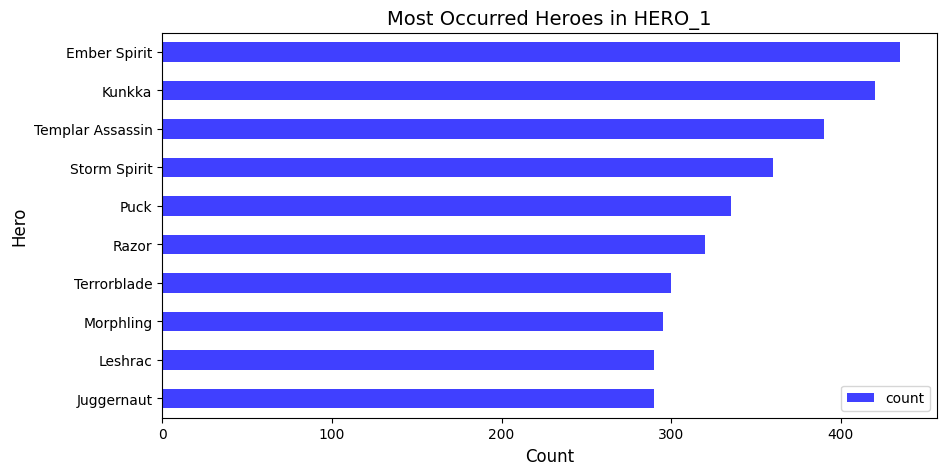

In [27]:
plott(df,1)

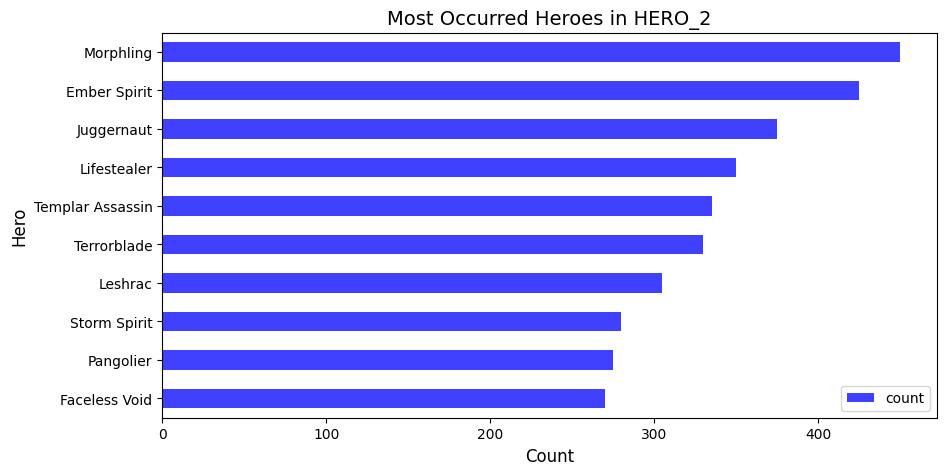

In [28]:
plott(df,2)

In [29]:
df.columns

['ID',
 'SIDE',
 'MATCH_ID',
 'TOURNAMENT',
 'MAP',
 'TEAM',
 'SCORE',
 'DURATION',
 'PICK',
 'HERO',
 'PRIZE',
 'WIN',
 'RESULT',
 'HERO_1',
 'HERO_2',
 'HERO_3',
 'HERO_4',
 'HERO_5',
 'DRAFT']

In [30]:
df.show(5)

+-------+----+--------+--------------------+---+----------+-----+--------+----+----------------+-----+---+------+----------+----------+----------------+------+------+--------------------+
|     ID|SIDE|MATCH_ID|          TOURNAMENT|MAP|      TEAM|SCORE|DURATION|PICK|            HERO|PRIZE|WIN|RESULT|    HERO_1|    HERO_2|          HERO_3|HERO_4|HERO_5|               DRAFT|
+-------+----+--------+--------------------+---+----------+-----+--------+----+----------------+-----+---+------+----------+----------+----------------+------+------+--------------------+
|001-1-D|dire|   001-1|The Chongqing Maj...|  1|Virtus.pro|    7|    1670|   5|          Medusa|    0|  0|  LOSE|Juggernaut|Grimstroke|Nature's Prophet|  Sven|Medusa|[Juggernaut, Grim...|
|001-1-D|dire|   001-1|The Chongqing Maj...|  1|Virtus.pro|    7|    1670|   4|            Sven|    0|  0|  LOSE|Juggernaut|Grimstroke|Nature's Prophet|  Sven|Medusa|[Juggernaut, Grim...|
|001-1-D|dire|   001-1|The Chongqing Maj...|  1|Virtus.pro| 

In [31]:
df.show(5)

+-------+----+--------+--------------------+---+----------+-----+--------+----+----------------+-----+---+------+----------+----------+----------------+------+------+--------------------+
|     ID|SIDE|MATCH_ID|          TOURNAMENT|MAP|      TEAM|SCORE|DURATION|PICK|            HERO|PRIZE|WIN|RESULT|    HERO_1|    HERO_2|          HERO_3|HERO_4|HERO_5|               DRAFT|
+-------+----+--------+--------------------+---+----------+-----+--------+----+----------------+-----+---+------+----------+----------+----------------+------+------+--------------------+
|001-1-D|dire|   001-1|The Chongqing Maj...|  1|Virtus.pro|    7|    1670|   5|          Medusa|    0|  0|  LOSE|Juggernaut|Grimstroke|Nature's Prophet|  Sven|Medusa|[Juggernaut, Grim...|
|001-1-D|dire|   001-1|The Chongqing Maj...|  1|Virtus.pro|    7|    1670|   4|            Sven|    0|  0|  LOSE|Juggernaut|Grimstroke|Nature's Prophet|  Sven|Medusa|[Juggernaut, Grim...|
|001-1-D|dire|   001-1|The Chongqing Maj...|  1|Virtus.pro| 

In [32]:

# Select only the 'TEAM', 'TOURNAMENT', and 'DURATION' columns
df1 = df.select('TEAM', 'TOURNAMENT', 'DURATION')
df1.show(5)

+----------+--------------------+--------+
|      TEAM|          TOURNAMENT|DURATION|
+----------+--------------------+--------+
|Virtus.pro|The Chongqing Maj...|    1670|
|Virtus.pro|The Chongqing Maj...|    1670|
|Virtus.pro|The Chongqing Maj...|    1670|
|Virtus.pro|The Chongqing Maj...|    1670|
|Virtus.pro|The Chongqing Maj...|    1670|
+----------+--------------------+--------+
only showing top 5 rows



In [33]:

# Convert 'DURATION' to total minutes
df1 = df1.withColumn('DURATION', df1['DURATION'] / 60)

# Aggregate data to get total duration for each team
df1 = df1.groupBy('TEAM').agg(F.sum('DURATION').alias('DURATION'))

# Select top 12 teams
df1 = df1.sort('DURATION', ascending=False)
top_teams = df1.limit(12)


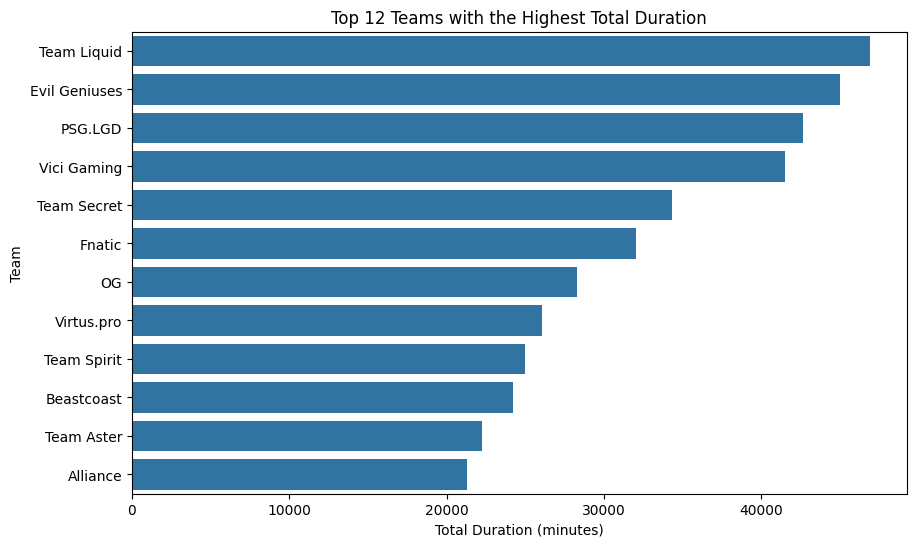

In [34]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
top_teams_pd = top_teams.toPandas()

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='DURATION', y='TEAM', data=top_teams_pd, order=top_teams_pd['TEAM'])
plt.xlabel('Total Duration (minutes)')
plt.ylabel('Team')
plt.title('Top 12 Teams with the Highest Total Duration')
plt.show()


In [35]:

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("matches")

# Use SQL queries to get the desired result
result = spark.sql("""
    SELECT MATCH_ID,
           CONCAT_WS(' vs ', COLLECT_LIST(TEAM)) as MATCH_PLAYED
    FROM (
        SELECT MATCH_ID, TEAM
        FROM matches
        GROUP BY MATCH_ID, TEAM
    ) 
    GROUP BY MATCH_ID
""")

result.show(5)


+--------+--------------------+
|MATCH_ID|        MATCH_PLAYED|
+--------+--------------------+
|   001-1| EHOME vs Virtus.pro|
|   001-2| Virtus.pro vs EHOME|
|   001-3| EHOME vs Virtus.pro|
|   002-1|TNC Predator vs C...|
|   002-2|TNC Predator vs C...|
+--------+--------------------+
only showing top 5 rows



In [36]:
# Register the df DataFrame as a SQL temporary view
df.createOrReplaceTempView("df")

# Get the DURATION column
df_duration = spark.sql("SELECT MATCH_ID, DURATION FROM df")

# Join the result DataFrame with df_duration
result_with_duration = result.join(df_duration, on='MATCH_ID', how='inner')

result_with_duration.show(5)


+--------+-------------------+--------+
|MATCH_ID|       MATCH_PLAYED|DURATION|
+--------+-------------------+--------+
|   001-1|EHOME vs Virtus.pro|    1670|
|   001-1|EHOME vs Virtus.pro|    1670|
|   001-1|EHOME vs Virtus.pro|    1670|
|   001-1|EHOME vs Virtus.pro|    1670|
|   001-1|EHOME vs Virtus.pro|    1670|
+--------+-------------------+--------+
only showing top 5 rows



In [37]:
# Drop duplicates based on 'MATCH_ID'
result_with_duration = result_with_duration.dropDuplicates(['MATCH_ID'])

result_with_duration.show(5)


+--------+--------------------+--------+
|MATCH_ID|        MATCH_PLAYED|DURATION|
+--------+--------------------+--------+
|   001-1| EHOME vs Virtus.pro|    1670|
|   001-2| Virtus.pro vs EHOME|    1383|
|   001-3| EHOME vs Virtus.pro|    2979|
|   002-1|TNC Predator vs C...|    2317|
|   002-2|TNC Predator vs C...|    1324|
+--------+--------------------+--------+
only showing top 5 rows



In [38]:

# Convert the Spark DataFrame to a Pandas DataFrame
df_pd = result_with_duration.toPandas()

# Convert the 'DURATION' column to numeric values
df_pd['DURATION'] = pd.to_numeric(df_pd['DURATION'])

# Get the top 10 matches by duration
top_10 = df_pd.nlargest(10, 'DURATION')

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_10['MATCH_PLAYED'], top_10['DURATION'], color='skyblue')
plt.xlabel('Duration')
plt.ylabel('Match Played')
plt.title('Top 10 Matches by Duration')
plt.gca().invert_yaxis()
plt.show()


NameError: name 'pd' is not defined

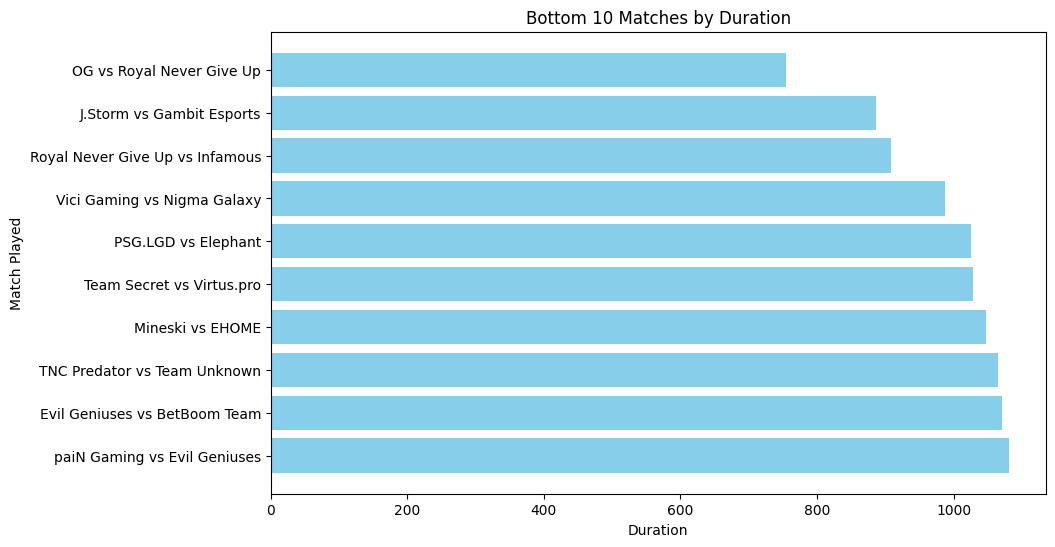

In [ ]:
# Get the bottom 10 matches by duration
bottom_10 = df_pd.nsmallest(10, 'DURATION')

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(bottom_10['MATCH_PLAYED'], bottom_10['DURATION'], color='skyblue')
plt.xlabel('Duration')
plt.ylabel('Match Played')
plt.title('Bottom 10 Matches by Duration')
plt.gca().invert_yaxis()
plt.show()


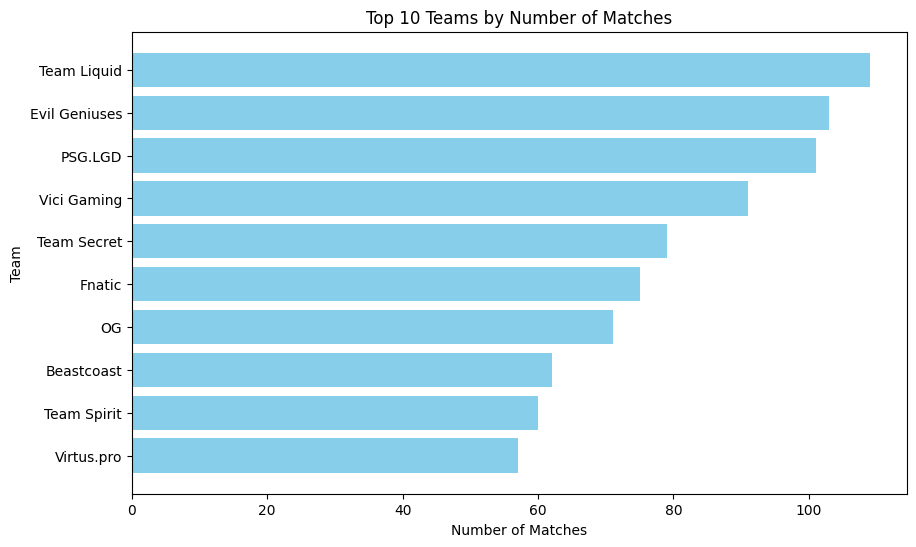

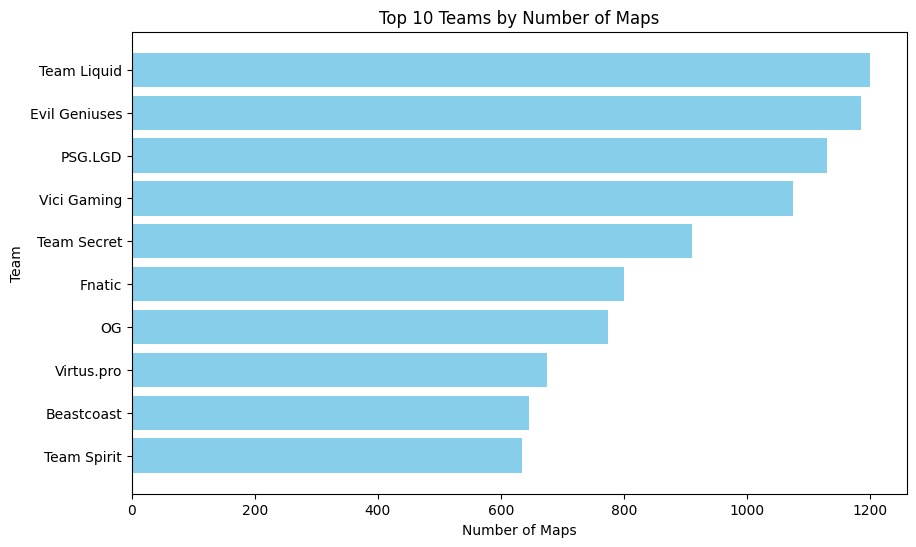

In [ ]:

# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("df")

# Use SQL queries to get the desired result
result = spark.sql("""
    SELECT TEAM,
           COUNT(DISTINCT split(MATCH_ID, '-')[0]) as NUM_MATCHES,
           COUNT(TEAM) as NUM_MAPS
    FROM df
    GROUP BY TEAM
""")

# Convert the Spark DataFrame to a Pandas DataFrame
result_pd = result.toPandas()

# Convert 'NUM_MATCHES' and 'NUM_MAPS' to numeric values
result_pd['NUM_MATCHES'] = pd.to_numeric(result_pd['NUM_MATCHES'])
result_pd['NUM_MAPS'] = pd.to_numeric(result_pd['NUM_MAPS'])

# Select top 10 teams by number of matches
top_teams_matches = result_pd.nlargest(10, 'NUM_MATCHES')

# Create a bar plot for 'NUM_MATCHES'
plt.figure(figsize=(10, 6))
plt.barh(top_teams_matches['TEAM'], top_teams_matches['NUM_MATCHES'], color='skyblue')
plt.xlabel('Number of Matches')
plt.ylabel('Team')
plt.title('Top 10 Teams by Number of Matches')
plt.gca().invert_yaxis()
plt.show()

# Select top 10 teams by number of maps
top_teams_maps = result_pd.nlargest(10, 'NUM_MAPS')

# Create a bar plot for 'NUM_MAPS'
plt.figure(figsize=(10, 6))
plt.barh(top_teams_maps['TEAM'], top_teams_maps['NUM_MAPS'], color='skyblue')
plt.xlabel('Number of Maps')
plt.ylabel('Team')
plt.title('Top 10 Teams by Number of Maps')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# Group by 'MATCH_ID' and 'TEAM', and count the number of occurrences
duplicates = df.groupBy('MATCH_ID', 'TEAM').count()

# Filter to get only the duplicates
duplicates = duplicates.filter(duplicates['count'] > 1)

# Show the number of duplicates
print(f"The DataFrame contains {duplicates.count()} duplicate (MATCH_ID, TEAM) pairs.")

# Drop duplicates based on 'MATCH_ID' and 'TEAM'
df = df.dropDuplicates(['MATCH_ID', 'TEAM'])

print("Duplicate (MATCH_ID, TEAM) pairs have been removed from the DataFrame.")


The DataFrame contains 3532 duplicate (MATCH_ID, TEAM) pairs.
Duplicate (MATCH_ID, TEAM) pairs have been removed from the DataFrame.


In [ ]:
# Calculate the sum of scores for each team
team_scores = df.groupBy('TEAM').agg(F.sum('SCORE').alias('TOTAL_SCORE'))

# Sort teams by total score
team_scores_sorted = team_scores.sort('TOTAL_SCORE', ascending=False)

# Select top 12 teams
top_teams_scores = team_scores_sorted.limit(12)

top_teams_scores.show()


+-------------+-----------+
|         TEAM|TOTAL_SCORE|
+-------------+-----------+
|      PSG.LGD|       5886|
|  Team Liquid|       5869|
|Evil Geniuses|       5772|
|  Vici Gaming|       5467|
|  Team Secret|       4787|
|           OG|       4093|
|       Fnatic|       3874|
|   Virtus.pro|       3201|
|   Beastcoast|       3060|
|  Team Spirit|       2905|
|   Team Aster|       2611|
|     Alliance|       2518|
+-------------+-----------+



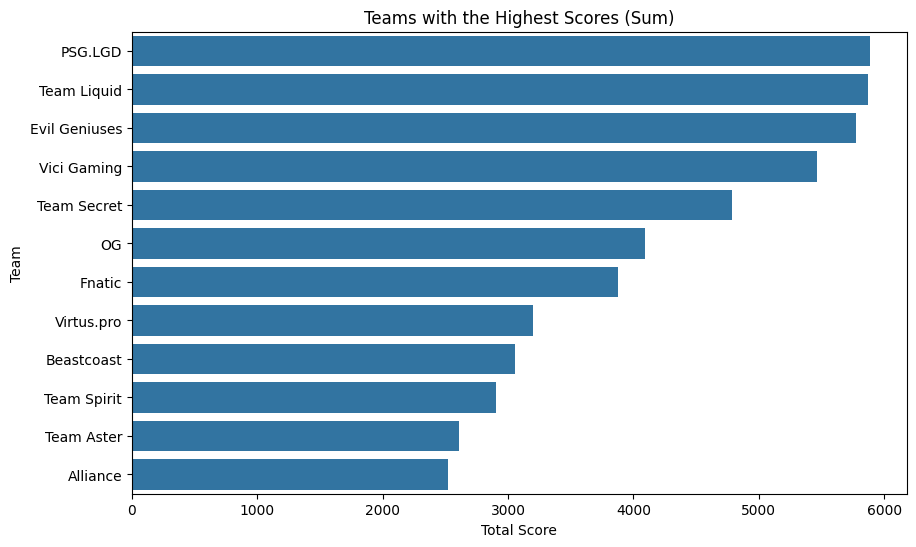

In [ ]:

# Convert the Spark DataFrame to a Pandas DataFrame
top_teams_scores_pd = top_teams_scores.toPandas()

# Convert 'TOTAL_SCORE' to numeric values
top_teams_scores_pd['TOTAL_SCORE'] = pd.to_numeric(top_teams_scores_pd['TOTAL_SCORE'])

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_teams_scores_pd['TOTAL_SCORE'], y=top_teams_scores_pd['TEAM'])
plt.title('Teams with the Highest Scores (Sum)')
plt.xlabel('Total Score')
plt.ylabel('Team')
plt.show()


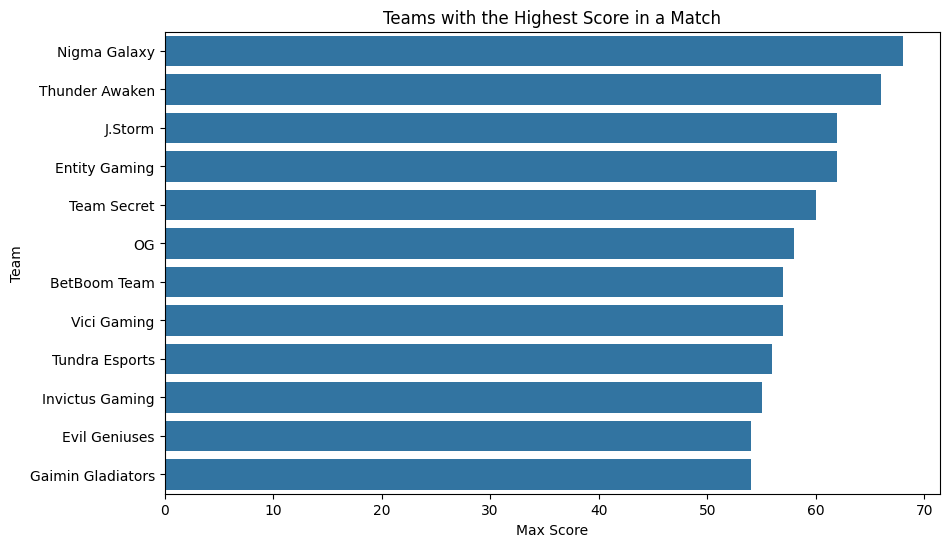

In [ ]:
team_max_scores = df.groupBy('TEAM').max('SCORE')

# Converting to Pandas for plotting
team_max_scores_pd = team_max_scores.toPandas().sort_values('max(SCORE)', ascending=False).head(12)

plt.figure(figsize=(10, 6))
sns.barplot(x=team_max_scores_pd['max(SCORE)'].values, y=team_max_scores_pd['TEAM'].values)
plt.title('Teams with the Highest Score in a Match')
plt.xlabel('Max Score')
plt.ylabel('Team')
plt.show()

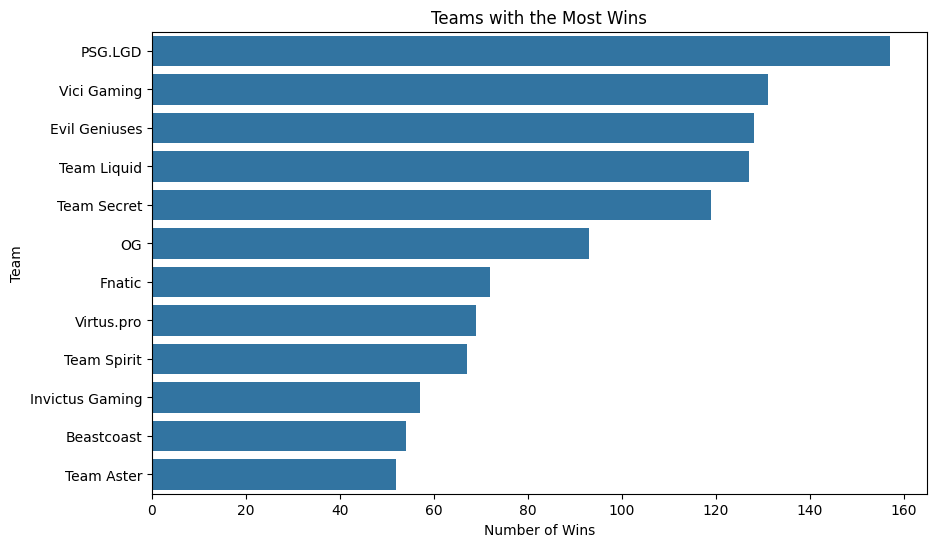

In [ ]:
team_wins = df.filter(df['RESULT'] == 'WIN').groupBy('TEAM').count()

# Converting to Pandas for plotting
team_wins_pd = team_wins.toPandas().sort_values('count', ascending=False).head(12)

plt.figure(figsize=(10, 6))
sns.barplot(x=team_wins_pd['count'].values, y=team_wins_pd['TEAM'].values)
plt.title('Teams with the Most Wins')
plt.xlabel('Number of Wins')
plt.ylabel('Team')
plt.show()

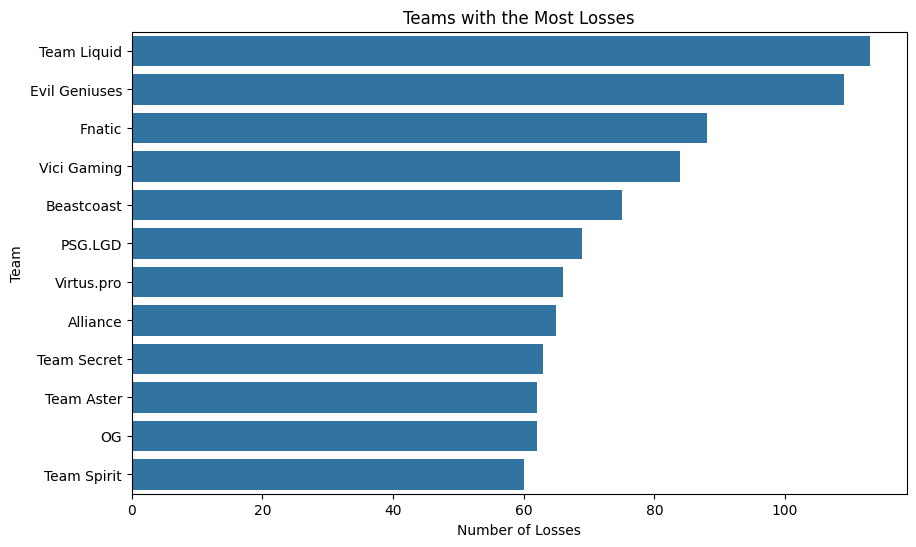

In [ ]:
team_losses= df.where(df['RESULT']=='LOSE').groupby('TEAM').count()
team_losses_pd=team_losses.toPandas().sort_values('count',ascending=False).head(12)
plt.figure(figsize=(10, 6))
sns.barplot(x=team_losses_pd['count'].values, y=team_losses_pd['TEAM'].values)
plt.title('Teams with the Most Losses')
plt.xlabel('Number of Losses')
plt.ylabel('Team')
plt.show()

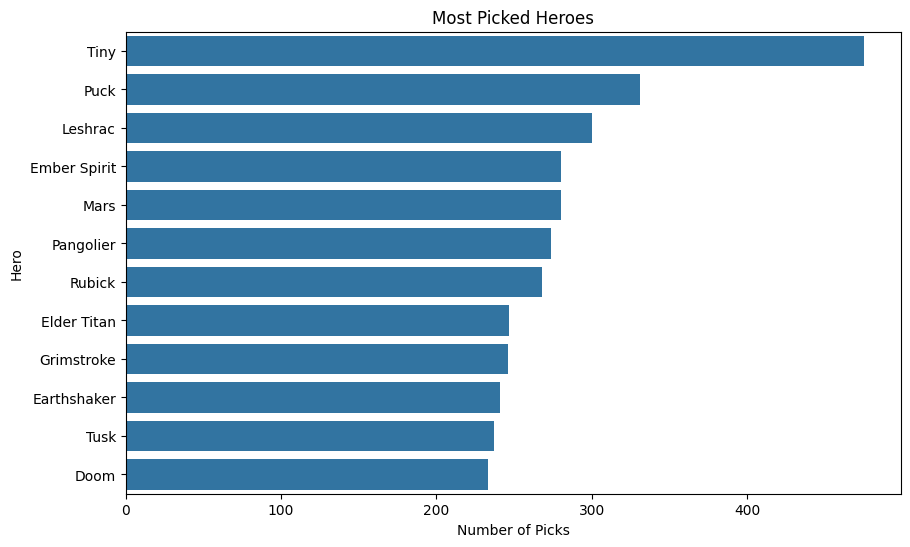

In [ ]:

heroes = df.select('HERO_1').union(df.select('HERO_2')).union(df.select('HERO_3')).union(df.select('HERO_4')).union(df.select('HERO_5'))

hero_counts = heroes.groupBy('HERO_1').count()

# Converting to Pandas for plotting
hero_counts_pd = hero_counts.toPandas().sort_values('count', ascending=False).head(12)

plt.figure(figsize=(10, 6))
sns.barplot(x=hero_counts_pd['count'].values, y=hero_counts_pd['HERO_1'].values)
plt.title('Most Picked Heroes')
plt.xlabel('Number of Picks')
plt.ylabel('Hero')
plt.show()


In [ ]:

wins = df.filter(df['RESULT'] == 'WIN')
losses = df.filter(df['RESULT'] == 'LOSE')

# Count number of wins and losses for each team
win_counts = wins.groupBy('TEAM').count().withColumnRenamed('count', 'NUM_WINS')
loss_counts = losses.groupBy('TEAM').count().withColumnRenamed('count', 'NUM_LOSSES')

# Merge win_counts and loss_counts
team_counts = win_counts.join(loss_counts, on='TEAM', how='outer')

# Fill missing values with 0
team_counts = team_counts.na.fill({'NUM_WINS': 0, 'NUM_LOSSES': 0})

# Calculate win-loss differential for each team
team_counts = team_counts.withColumn('WIN_LOSS_DIFF', col('NUM_WINS') - col('NUM_LOSSES'))

# Sort teams by win-loss differential
team_diff_sorted = team_counts.sort(col('WIN_LOSS_DIFF').desc())

# Select top 10 teams
top_teams_diff = team_diff_sorted.limit(10)

# Select bottom 10 teams
bottom_teams_diff = team_diff_sorted.orderBy(col('WIN_LOSS_DIFF')).limit(10)


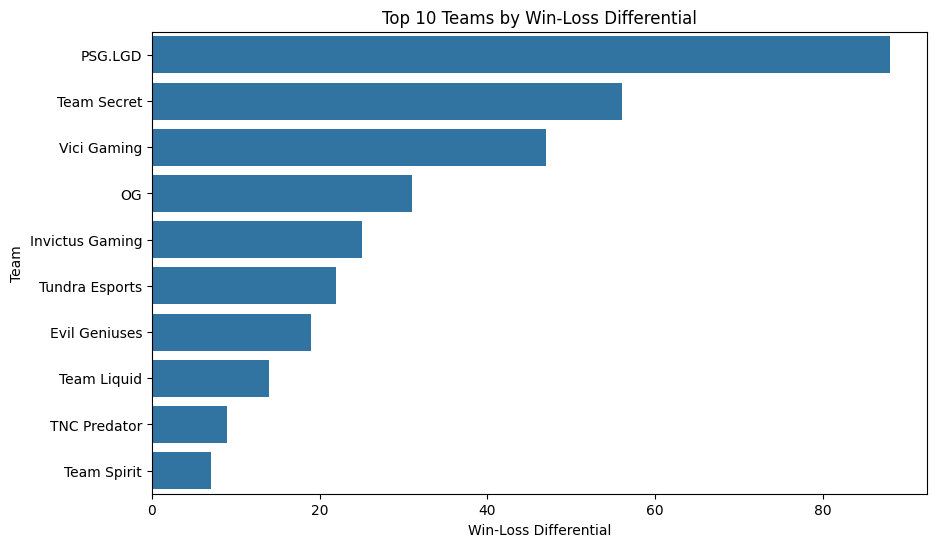

In [ ]:
# Converting to Pandas for plotting
top_teams_diff_pd = top_teams_diff.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x=top_teams_diff_pd['WIN_LOSS_DIFF'].values, y=top_teams_diff_pd['TEAM'].values)
plt.title('Top 10 Teams by Win-Loss Differential')
plt.xlabel('Win-Loss Differential')
plt.ylabel('Team')
plt.show()

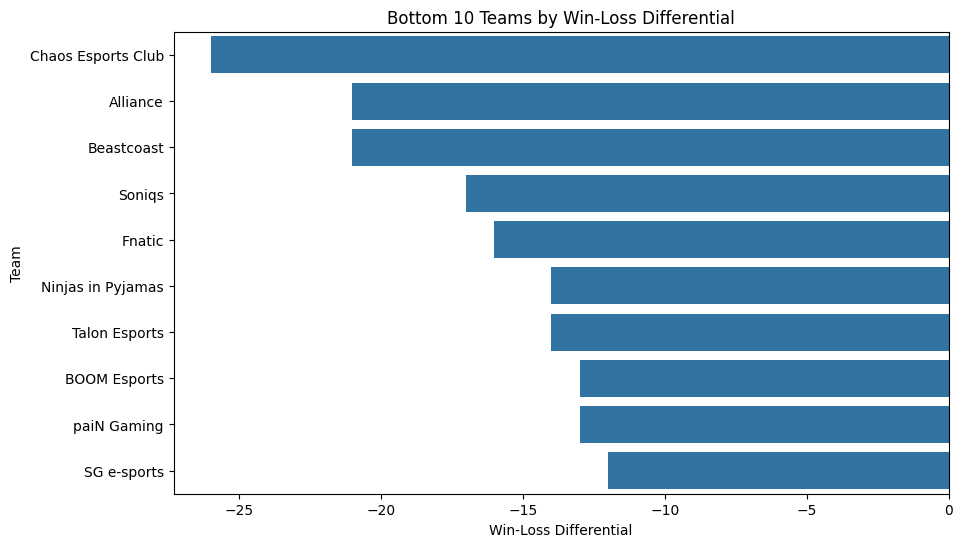

In [ ]:

# Converting to Pandas for plotting
bottom_teams_diff_pd = bottom_teams_diff.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x=bottom_teams_diff_pd['WIN_LOSS_DIFF'].values, y=bottom_teams_diff_pd['TEAM'].values)
plt.title('Bottom 10 Teams by Win-Loss Differential')
plt.xlabel('Win-Loss Differential')
plt.ylabel('Team')
plt.show()


In [ ]:
total_prize = df.groupBy('Tournament').sum('Prize')

# Show the DataFrame
total_prize.show()

+--------------------+----------+
|          Tournament|sum(Prize)|
+--------------------+----------+
|The International...|       193|
|The International...|       194|
|ESL One Stockholm...|       123|
|The Leipzig Major...|        96|
|PGL Arlington Maj...|       176|
|The Chongqing Maj...|        91|
|The International...|       231|
|Epicenter Major 2019|        96|
|WePlay AniMajor 2021|       137|
|MDL Disneyland Pa...|        95|
|The Stockholm Maj...|       101|
|ONE Esports Singa...|       135|
|MDL Chengdu Major...|        98|
+--------------------+----------+



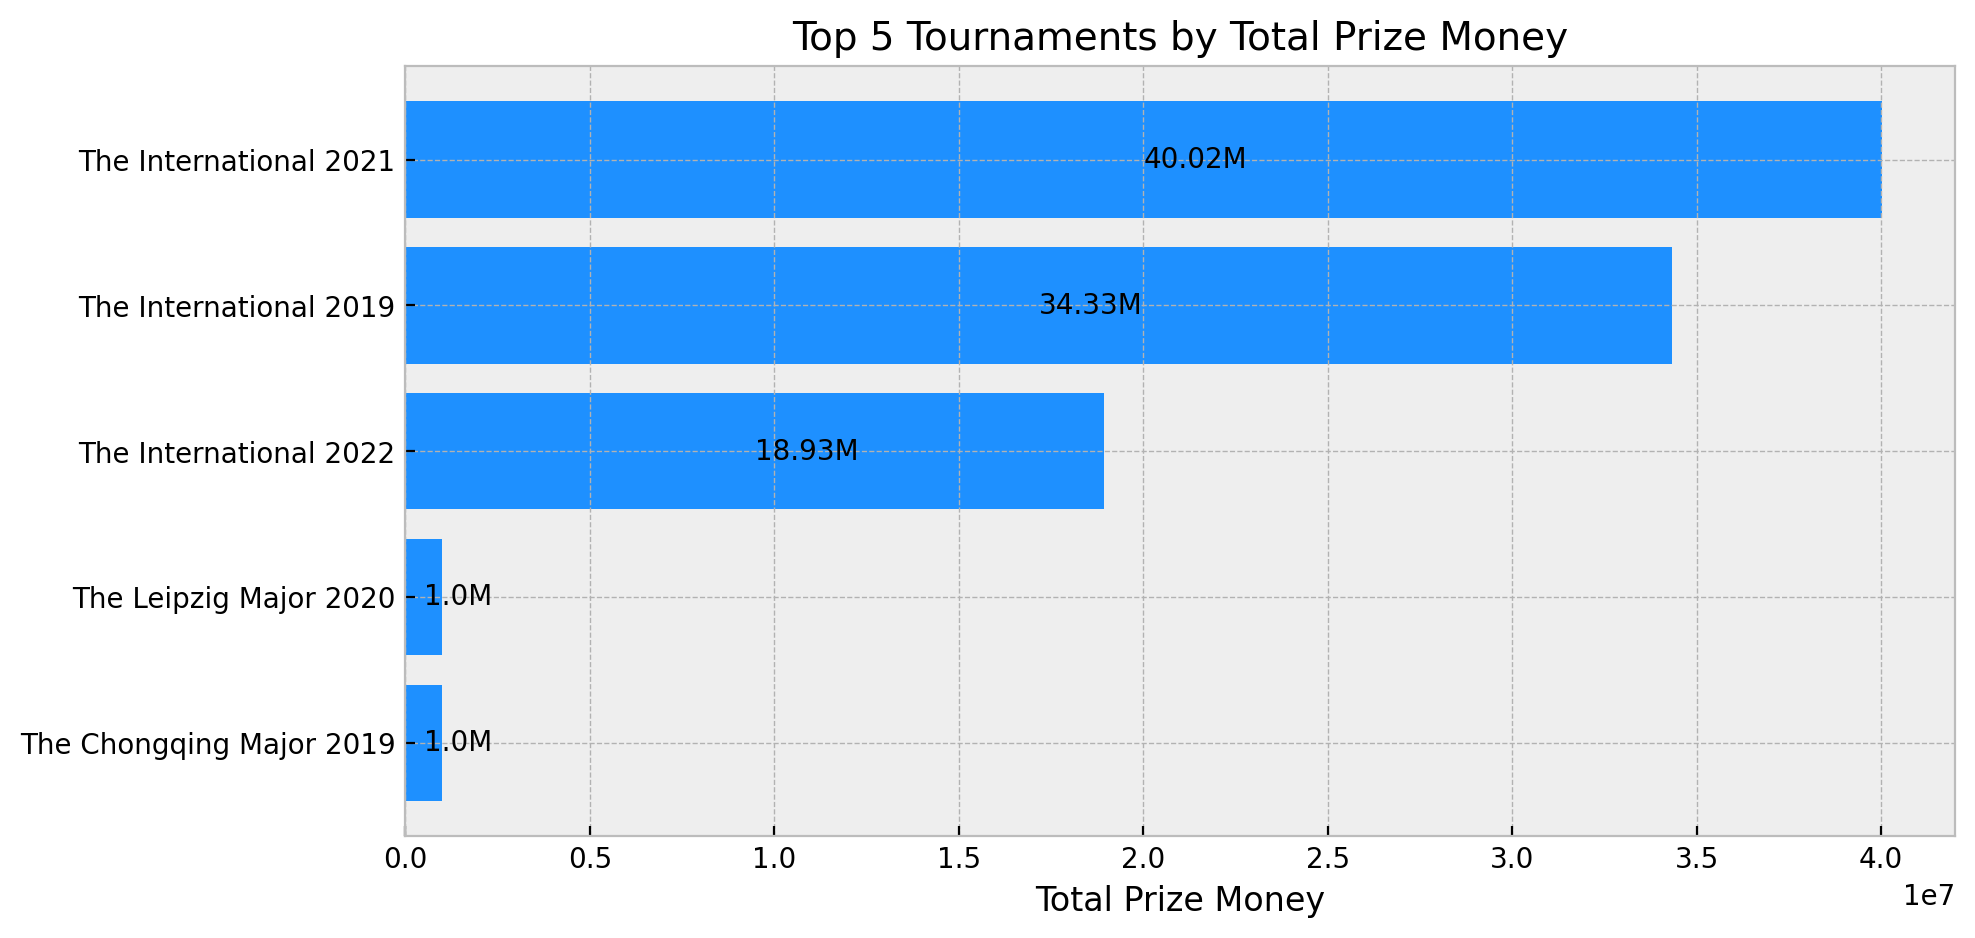

In [ ]:
total_prize = prize.groupBy('Tournament').sum('Prize')

# Converting to Pandas for plotting
total_prize_pd = total_prize.toPandas().sort_values('sum(Prize)', ascending=False)

# Get the top 5 tournaments
top_5 = total_prize_pd.head(5)

# Function to format prize value
def format_prize(value):
    # Convert the prize value to millions and round to 2 decimal places
    return f'{__builtins__.round(value / 1_000_000, 2)}M'


# Increase resolution
plt.rcParams['figure.dpi'] = 200

# Use a built-in matplotlib style
plt.style.use('bmh')

# Plot the top 5 tournaments
plt.figure(figsize=(10,5))
bars = plt.barh(top_5['Tournament'].values, top_5['sum(Prize)'].values, color='dodgerblue')
plt.xlabel('Total Prize Money', fontsize=12)
plt.title('Top 5 Tournaments by Total Prize Money', fontsize=14)
# Use numpy's max function instead of PySpark's max function
plt.xticks(np.arange(0, np.max(top_5['sum(Prize)'].values)+1, step=5000000), fontsize=10)
for bar in bars:
    width = bar.get_width()
    plt.text(width - width/2, bar.get_y() + bar.get_height()/2, format_prize(width), va='center', color='black', fontsize=10)
plt.gca().invert_yaxis()
plt.yticks(fontsize=10)

plt.show()


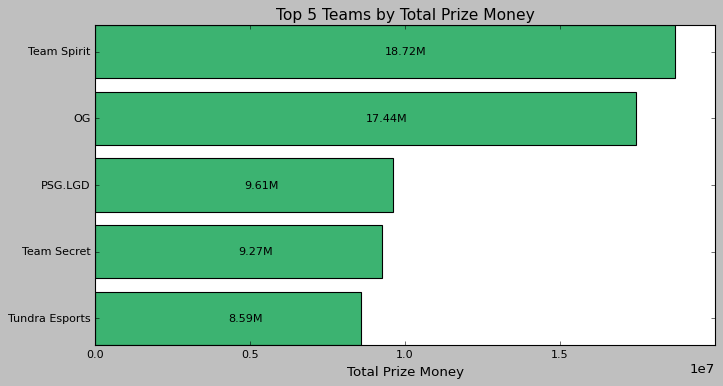

In [ ]:

team_prizes = prize.groupBy('Team').sum('Prize')

# Converting to Pandas for plotting
team_prizes_pd = team_prizes.toPandas().sort_values('sum(Prize)', ascending=False)

# Get the top 5 teams
top_5_teams = team_prizes_pd.head(5)

# Function to format prize value
def format_prize(value):
    # Convert the prize value to millions and round to 2 decimal places
    return f'{__builtin__.round(value / 1_000_000, 2)}M'

# Increase resolution
plt.rcParams['figure.dpi'] = 200

# Use a built-in matplotlib style
plt.style.use('classic')

# Plot the top 5 teams
plt.figure(figsize=(10,5))
bars = plt.barh(top_5_teams['Team'].values, top_5_teams['sum(Prize)'].values, color='mediumseagreen')
plt.xlabel('Total Prize Money', fontsize=12)
plt.title('Top 5 Teams by Total Prize Money', fontsize=14)
plt.xticks(np.arange(0, np.max(top_5_teams['sum(Prize)'].values)+1, step=5000000), fontsize=10)
for bar in bars:
    width = bar.get_width()
    plt.text(width - width/2, bar.get_y() + bar.get_height()/2, format_prize(width), va='center', color='black', fontsize=10)
plt.gca().invert_yaxis()
plt.yticks(fontsize=10)

plt.show()


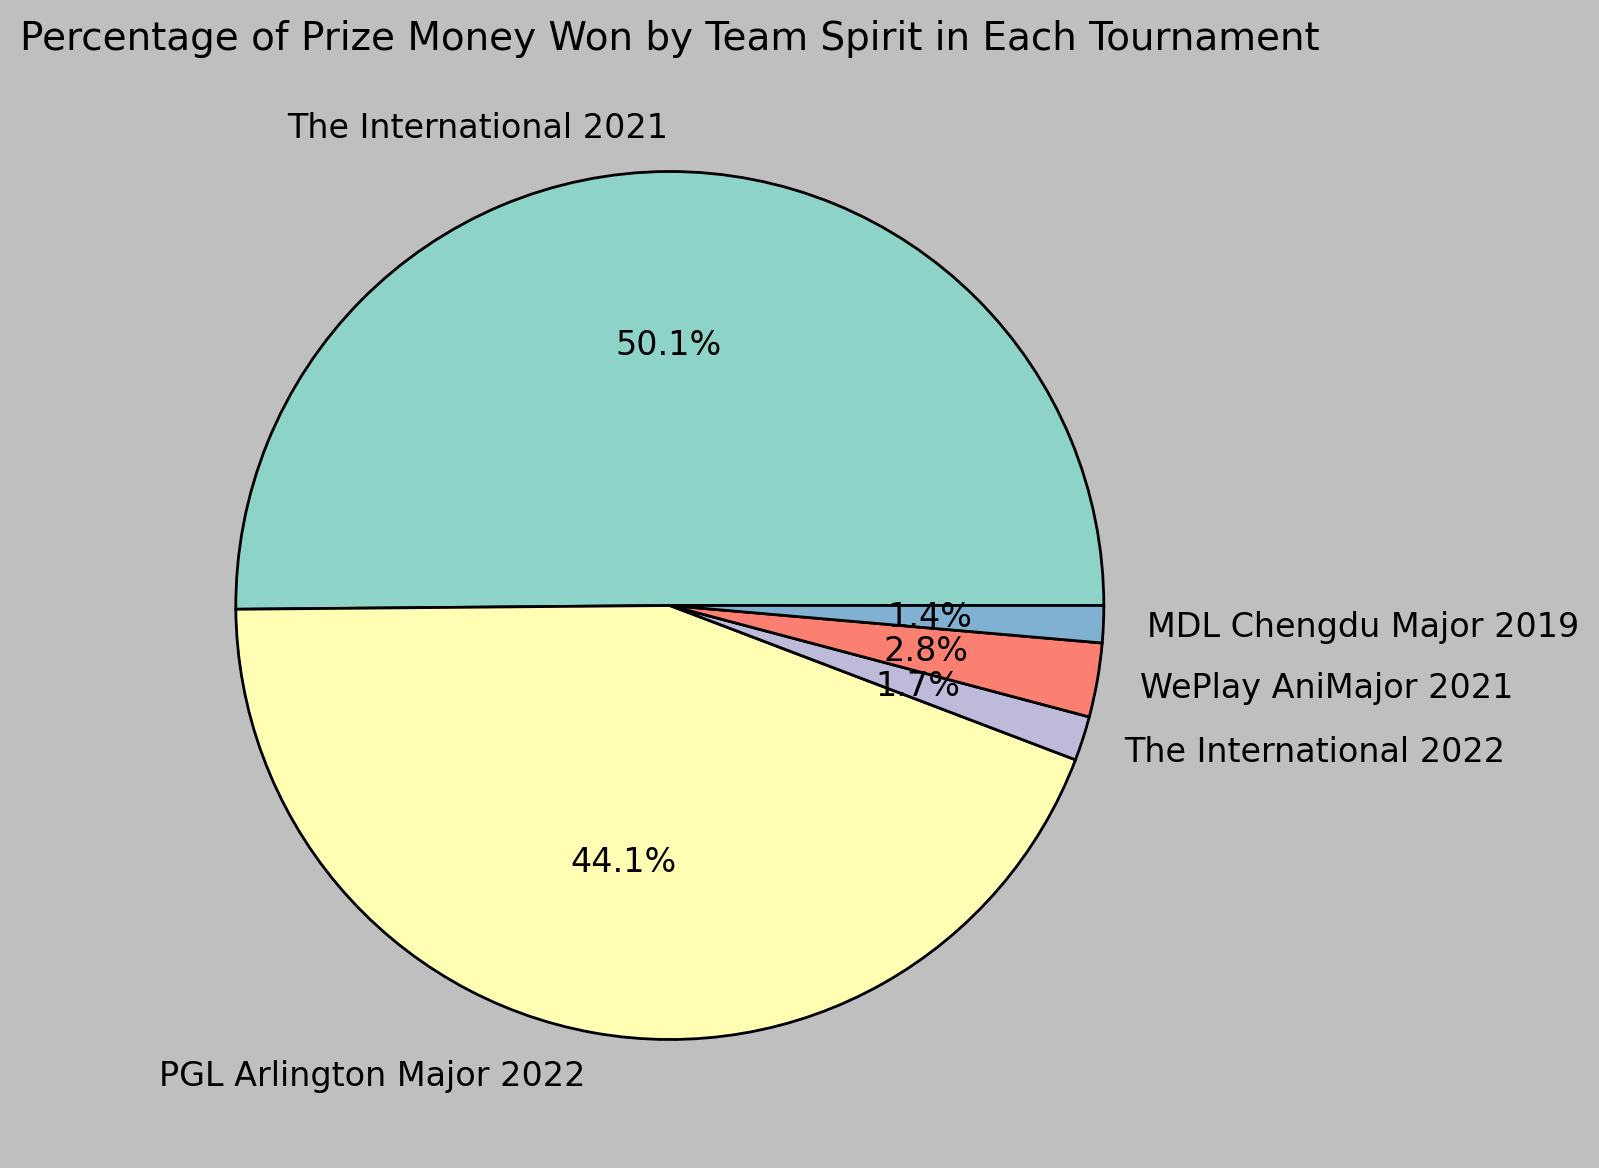

In [ ]:
team_spirit = prize.filter(prize['Team'] == 'Team Spirit')

# Group by 'Tournament' and sum the 'Prize' values
tournament_prizes = prize.groupBy('Tournament').agg(sum('Prize').alias('TotalPrize'))
team_spirit_prizes = team_spirit.groupBy('Tournament').agg(sum('Prize').alias('TeamSpiritPrize'))

# Join the two dataframes
percentage_df = tournament_prizes.join(team_spirit_prizes, 'Tournament')

# Calculate the percentage of prize money that 'Team Spirit' won in each tournament
percentage_df = percentage_df.withColumn('Percentage', (col('TeamSpiritPrize') / col('TotalPrize')) * 100)

# Drop NaN values
percentage_df = percentage_df.na.drop()

# Converting to Pandas for plotting
percentage_pd = percentage_df.toPandas()

# Increase resolution
plt.rcParams['figure.dpi'] = 200

# Use a built-in matplotlib style
plt.style.use('tableau-colorblind10')

# Plot the results
plt.figure(figsize=(7,7))
wedges, texts, autotexts = plt.pie(percentage_pd['Percentage'], labels=percentage_pd['Tournament'], autopct='%1.1f%%', textprops={'fontsize': 10}, colors=plt.cm.Set3.colors)
plt.title('Percentage of Prize Money Won by Team Spirit in Each Tournament', fontsize=14)

# Increase the font size of the labels and the percentages
for text in texts:
    text.set_fontsize(12)
for autotext in autotexts:
    autotext.set_fontsize(12)

plt.show()


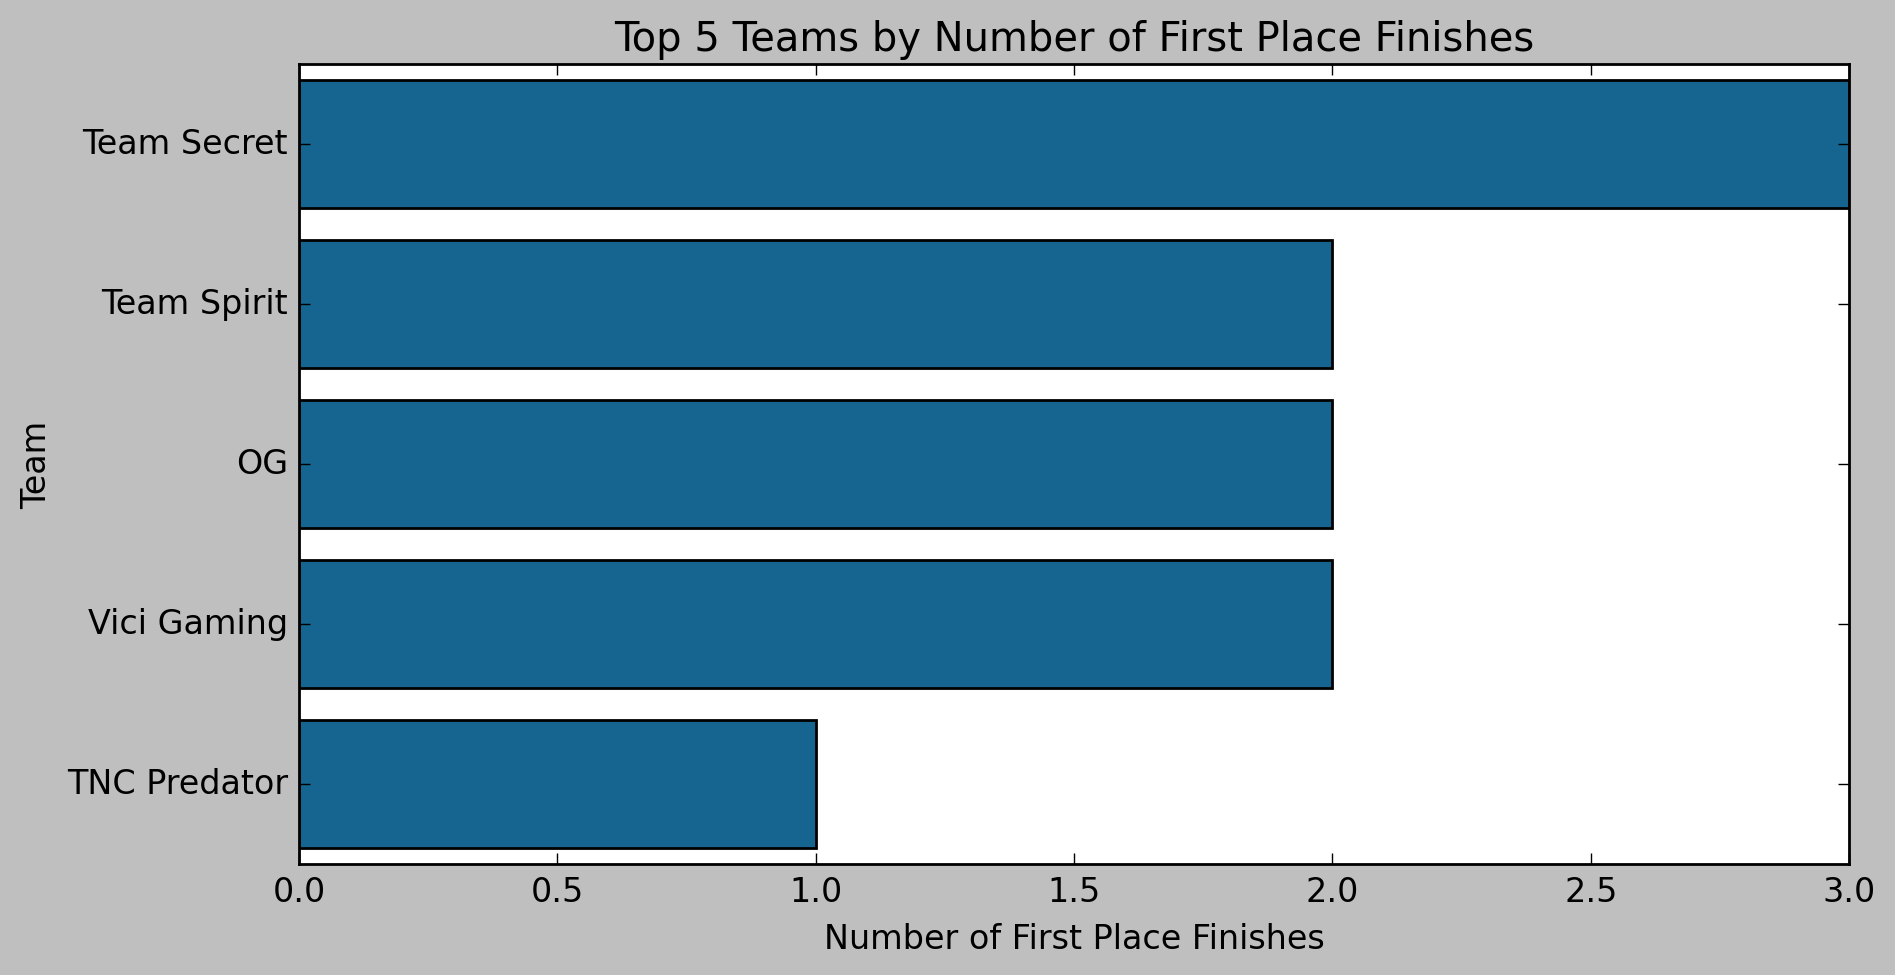

In [ ]:
first_place_counts = prize.filter(prize['Place'] == 1).groupBy('Team').count()

# Converting to Pandas for plotting
first_place_counts_pd = first_place_counts.toPandas().sort_values('count', ascending=False)

# Get the top 5 teams with the most first place finishes
top_5_first_place = first_place_counts_pd.head(5)

# Plot the results
plt.figure(figsize=(10,5))
sns.barplot(x=top_5_first_place['count'], y=top_5_first_place['Team'])
plt.xlabel('Number of First Place Finishes')
plt.ylabel('Team')
plt.title('Top 5 Teams by Number of First Place Finishes')
plt.show()


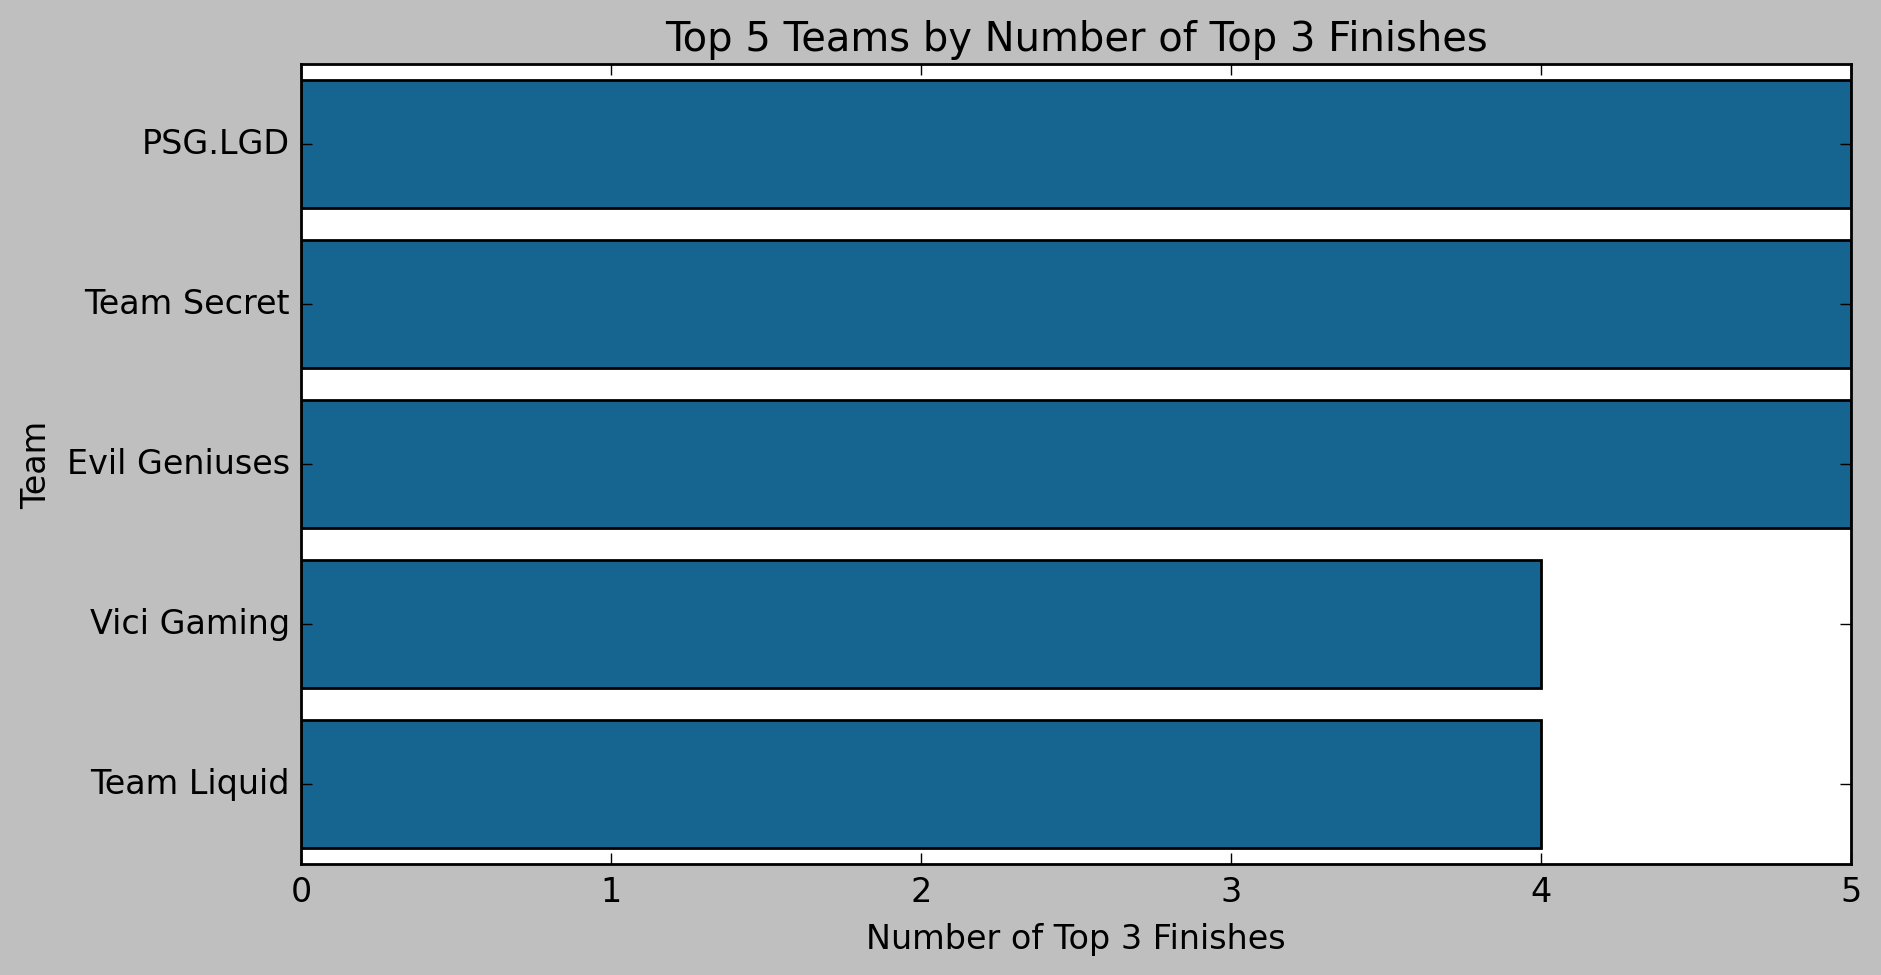

In [ ]:
top_3_counts = prize.filter(prize['Place'] <= 3).groupBy('Team').count()

# Converting to Pandas for plotting
top_3_counts_pd = top_3_counts.toPandas().sort_values('count', ascending=False)

# Get the top 5 teams with the most top 3 finishes
top_5_top_3 = top_3_counts_pd.head(5)

# Plot the results
plt.figure(figsize=(10,5))
sns.barplot(x=top_5_top_3['count'], y=top_5_top_3['Team'])
plt.xlabel('Number of Top 3 Finishes')
plt.ylabel('Team')
plt.title('Top 5 Teams by Number of Top 3 Finishes')
plt.show()


In [ ]:

team_secret = prize.filter(prize['Team'] == 'Team Secret')

# Count the number of times 'Team Secret' has finished in each place
place_counts = team_secret.groupBy('Place').count()

# Calculate the number of tournaments 'Team Secret' did not participate in
non_participation = df.select('Tournament').distinct().count() - team_secret.select('Tournament').distinct().count()

# Add non-participation to place_counts
non_participation_df = spark.createDataFrame([('Did not participate', non_participation)], ['Place', 'count'])
place_counts = place_counts.union(non_participation_df)

# Show the number of participations
print(f'Team Secret has participated in {team_secret.count()} tournaments.')


Team Secret has participated in 9 tournaments.


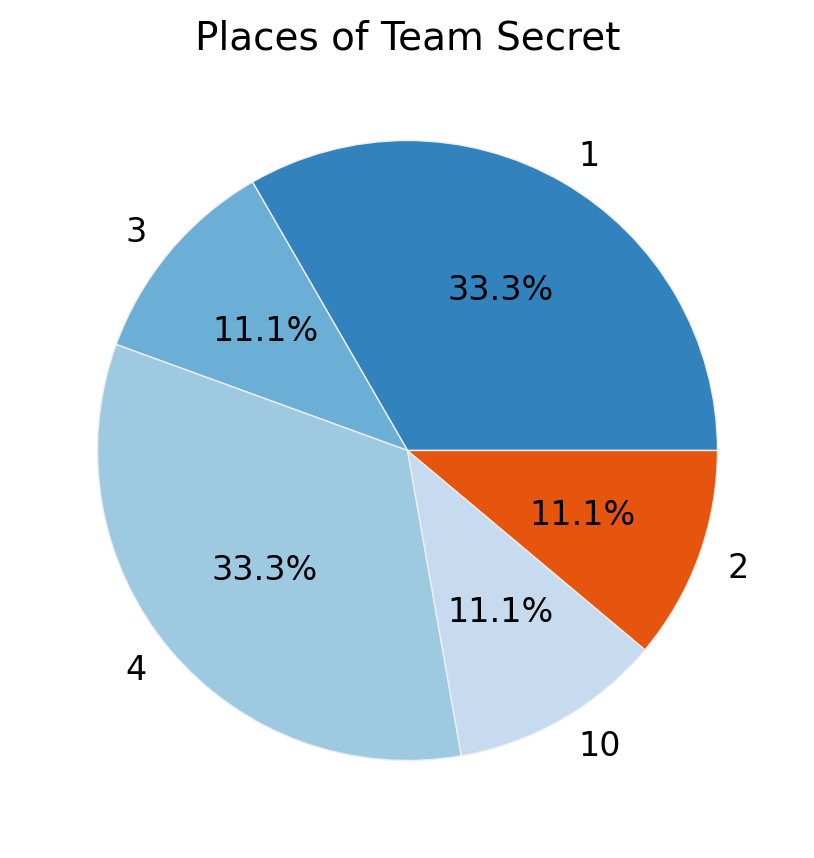

In [ ]:
team_secret = prize.filter(prize['Team'] == 'Team Secret')

# Count the number of times 'Team Secret' has finished in each place
place_counts = team_secret.groupBy('Place').count()

# Converting to Pandas for plotting
place_counts_pd = place_counts.toPandas()

# Increase resolution
plt.rcParams['figure.dpi'] = 200

# Use a built-in matplotlib style
plt.style.use('ggplot')

# Plot the results
plt.figure(figsize=(5,5))
wedges, texts, autotexts = plt.pie(place_counts_pd['count'], labels=place_counts_pd['Place'], autopct='%1.1f%%', textprops={'fontsize': 10}, colors=plt.cm.tab20c.colors)
plt.title('Places of Team Secret', fontsize=14)

# Increase the font size of the labels and the percentages
for text in texts:
    text.set_fontsize(12)
for autotext in autotexts:
    autotext.set_fontsize(12)

plt.show()


In [ ]:
df.columns

['ID',
 'SIDE',
 'MATCH_ID',
 'TOURNAMENT',
 'MAP',
 'TEAM',
 'SCORE',
 'DURATION',
 'PICK',
 'HERO',
 'PRIZE',
 'WIN',
 'RESULT',
 'HERO_1',
 'HERO_2',
 'HERO_3',
 'HERO_4',
 'HERO_5',
 'DRAFT']

In [ ]:
# Define the window
window = Window.partitionBy('MATCH_ID')

# Create the 'Match' column
df0 = df.withColumn('Match', F.concat_ws(' vs ', F.collect_set('TEAM').over(window)))

# Create the 'Score' column
df0 = df0.withColumn('Score', F.concat_ws('-', F.collect_list('SCORE').over(window)))

# Create the 'Win' column
df0 = df0.withColumn('Win', F.first('WIN').over(window))

# Drop duplicates
df0 = df0.dropDuplicates(['MATCH_ID'])


In [ ]:
# Create a 'Teams' column with sorted team names to ensure 'Virtus.pro vs EHOME' equals 'EHOME vs Virtus.pro'
split_col = F.split(df0['Match'], ' vs ')
df0 = df0.withColumn('Teams', F.when(split_col.getItem(0) < split_col.getItem(1), df0['Match']).otherwise(F.concat(split_col.getItem(1), F.lit(' vs '), split_col.getItem(0))))

# Filter the DataFrame to include only rows where 'MAP' is 1
df_map1 = df0.filter(df0['MAP'] == 1)

# Count the occurrence of each match
match_counts = df_map1.groupBy('Teams').count()

# Take only the top ten most occurred matches
top_ten_matches = match_counts.orderBy('count', ascending=False).limit(10)

# Show the top ten most occurred matches
top_ten_matches.show()


+--------------------+-----+
|               Teams|count|
+--------------------+-----+
|PSG.LGD vs Team L...|    9|
|Evil Geniuses vs ...|    9|
|Evil Geniuses vs ...|    9|
|Team Liquid vs Vi...|    8|
|PSG.LGD vs Vici G...|    8|
| Evil Geniuses vs OG|    7|
|PSG.LGD vs Team S...|    7|
|       OG vs PSG.LGD|    6|
|Team Secret vs Vi...|    6|
|Evil Geniuses vs ...|    6|
+--------------------+-----+



<Figure size 2000x1200 with 0 Axes>

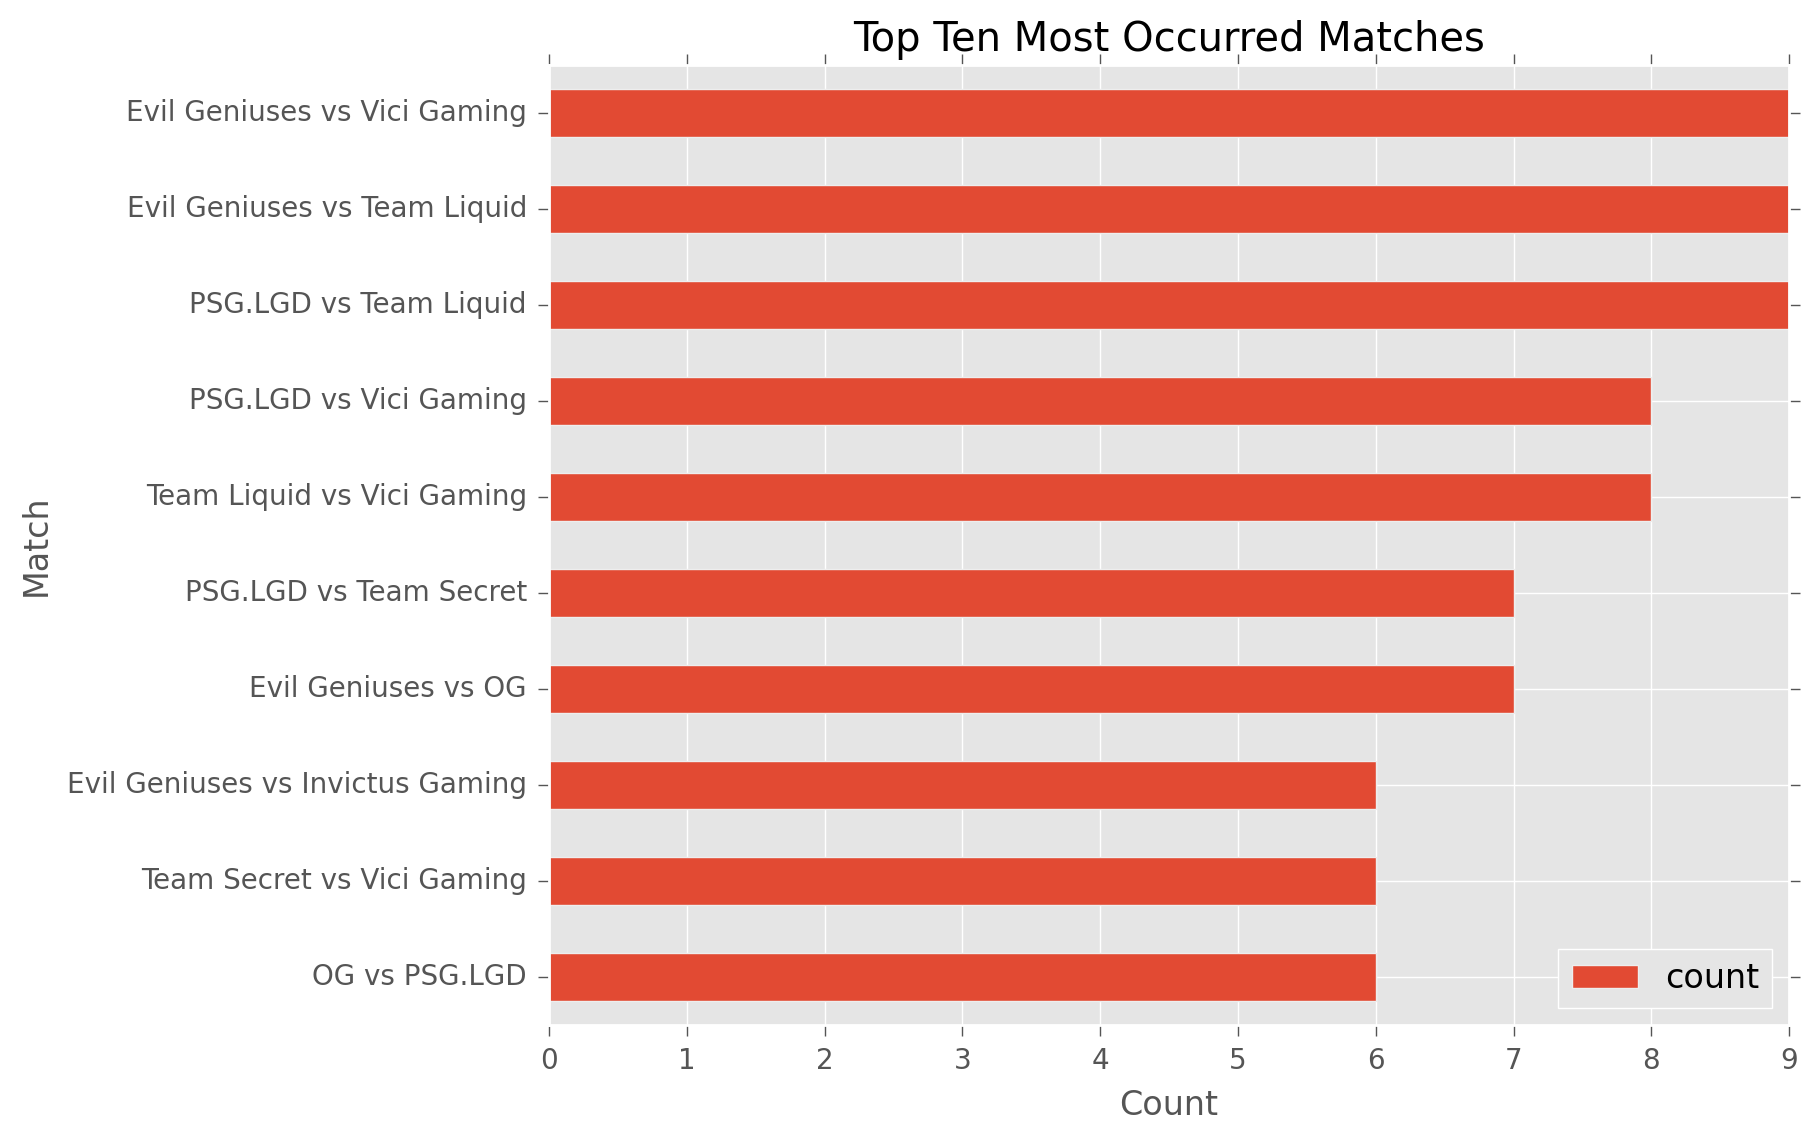

In [ ]:
# Convert to Pandas DataFrame
top_ten_matches_pd = top_ten_matches.toPandas()

# Plot the top ten most occurred matches as a horizontal bar plot
plt.figure(figsize=(10,6))
top_ten_matches_pd.sort_values('count').plot(kind='barh', x='Teams', y='count')
plt.title('Top Ten Most Occurred Matches')
plt.xlabel('Count')
plt.ylabel('Match')
plt.show()


In [ ]:
# Calculate the win counts for 'dire' and 'radiant' sides
win_counts = df0.filter(df0['WIN'] == 1).groupBy('SIDE').count()

# Calculate the total number of wins
total_wins = win_counts.groupBy().sum().collect()[0][0]

# Calculate the win percentages
win_percentages = win_counts.withColumn('Percentage', (F.col('count') / total_wins) * 100)

# Show the win percentages
win_percentages.show()


+-------+-----+-----------------+
|   SIDE|count|       Percentage|
+-------+-----+-----------------+
|   dire|  394|            49.25|
|radiant|  406|50.74999999999999|
+-------+-----+-----------------+



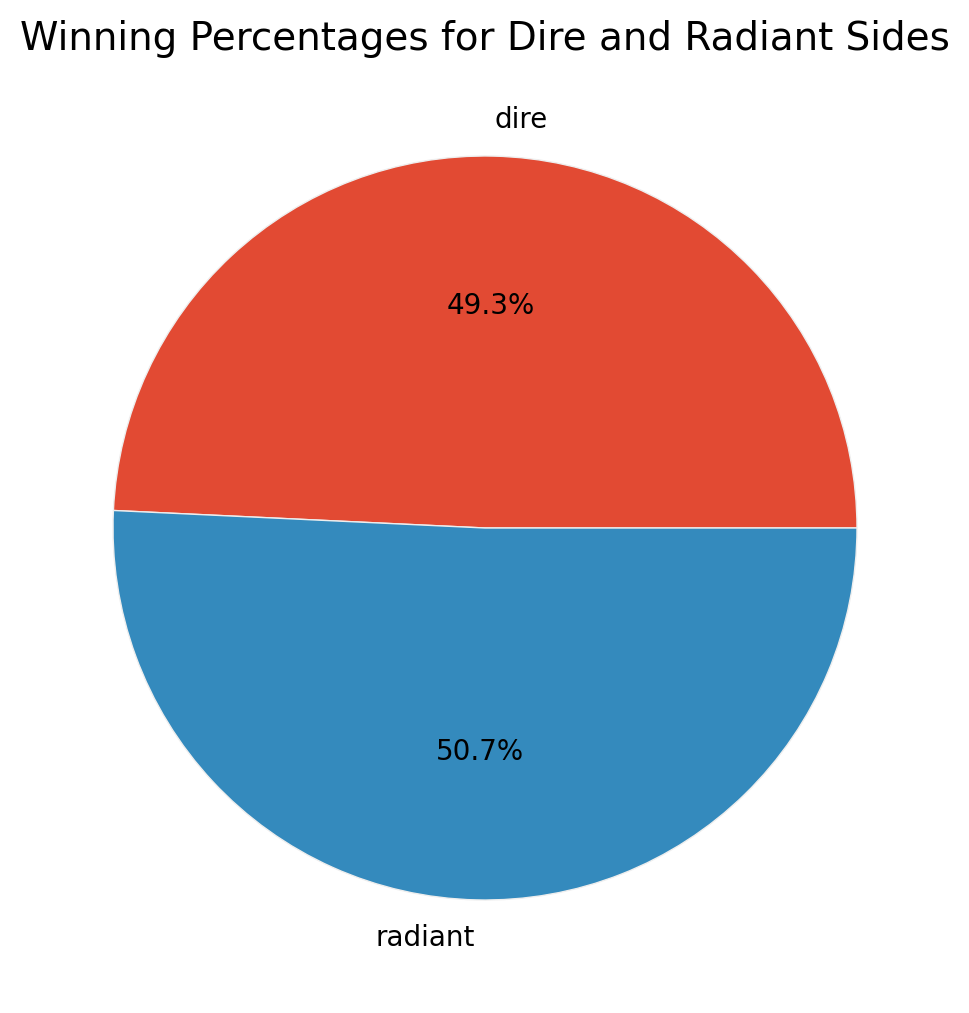

In [ ]:
# Convert to Pandas DataFrame
win_percentages_pd = win_percentages.toPandas()

# Plot the win percentages as a pie plot
plt.figure(figsize=(6,6))
plt.pie(win_percentages_pd['Percentage'], labels=win_percentages_pd['SIDE'], autopct='%1.1f%%', textprops={'fontsize': 10})
plt.title('Winning Percentages for Dire and Radiant Sides', fontsize=14)
plt.show()


In [ ]:
# Filter the DataFrame to include only rows where 'MAP' is 3
df0_map3 = df0.filter(df0['MAP'] == 3)

# Count the occurrence of each match
match_counts = df0_map3.groupBy('Teams').count()

# Take only the top ten most occurred matches
top_ten_matches3 = match_counts.orderBy('count', ascending=False).limit(10)

# Show the top ten most occurred matches
top_ten_matches3.show()


+--------------------+-----+
|               Teams|count|
+--------------------+-----+
|Evil Geniuses vs ...|    5|
|Team Secret vs Vi...|    4|
|Ninjas in Pyjamas...|    4|
|Evil Geniuses vs ...|    4|
|Evil Geniuses vs ...|    3|
|Evil Geniuses vs ...|    3|
|Team Liquid vs Vi...|    3|
|Vici Gaming vs Vi...|    3|
|TNC Predator vs V...|    3|
|Evil Geniuses vs ...|    2|
+--------------------+-----+



<Figure size 2000x1200 with 0 Axes>

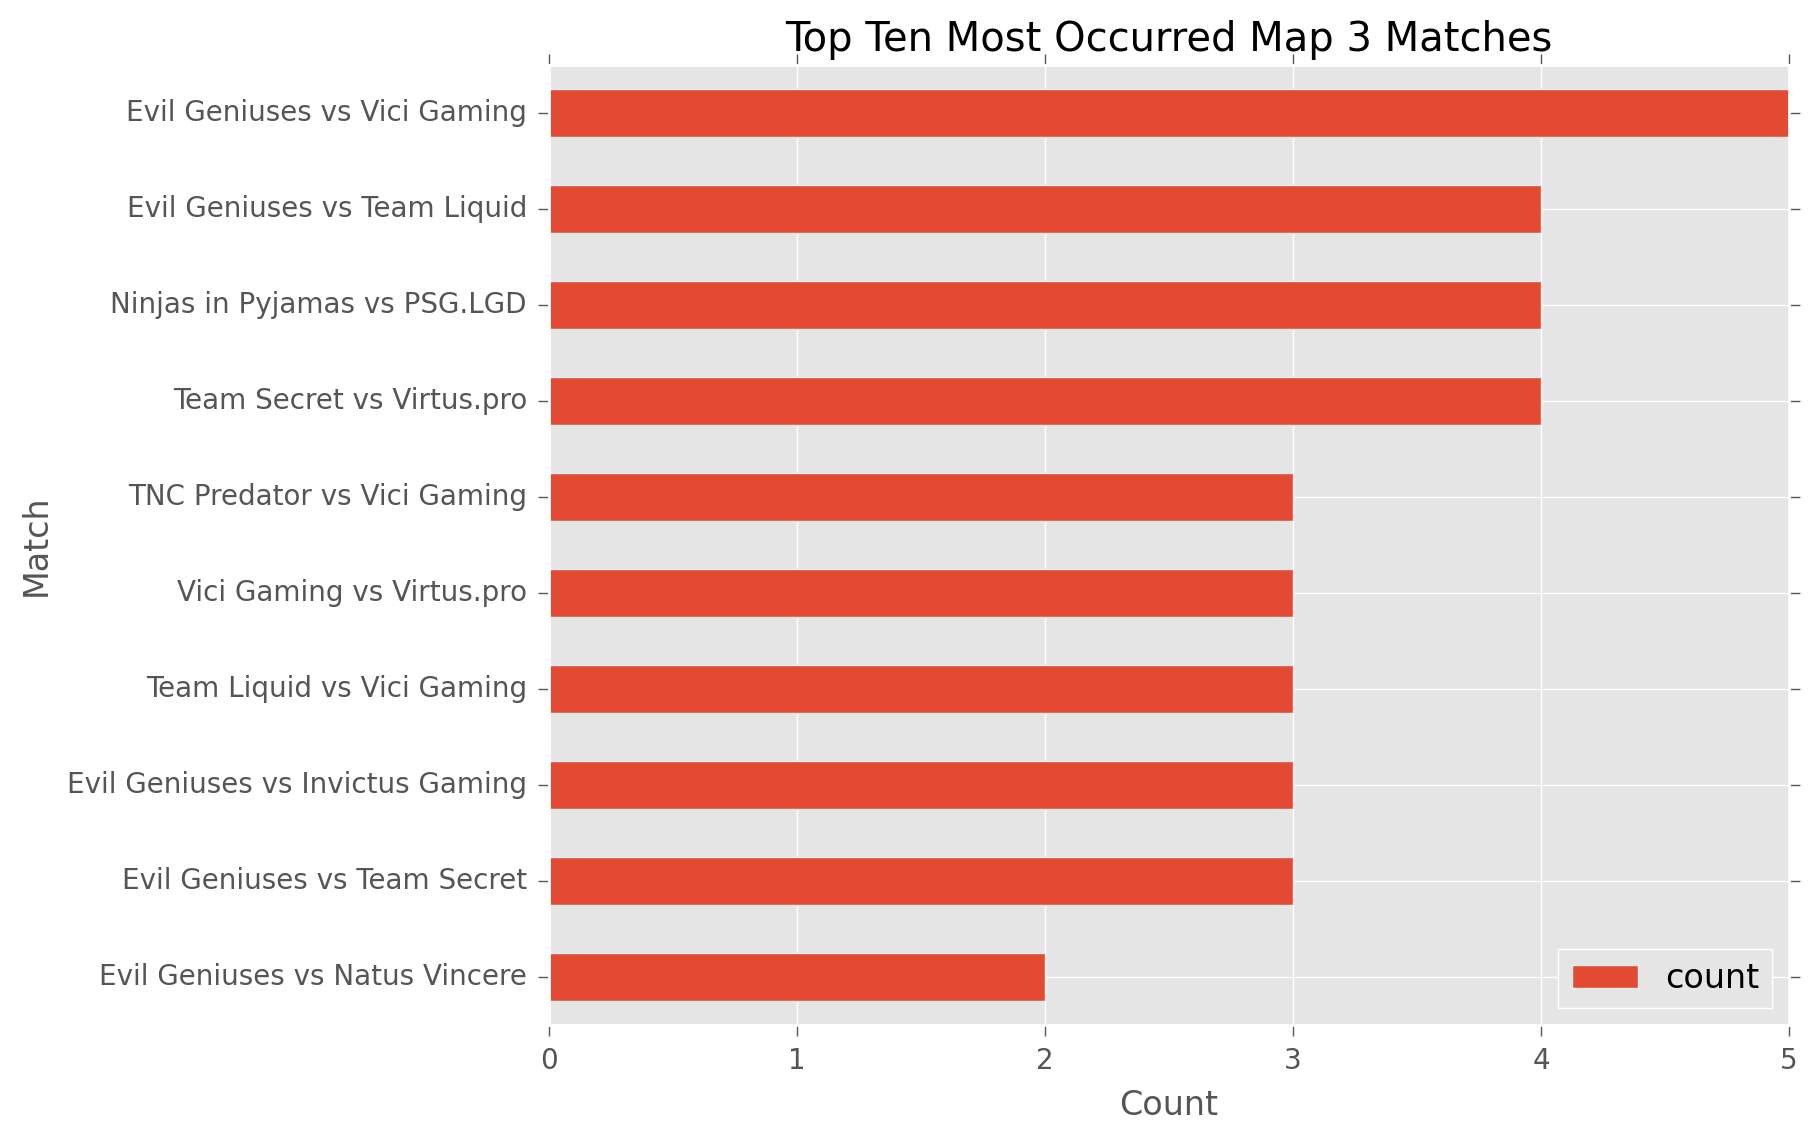

In [ ]:
# Convert to Pandas DataFrame
top_ten_matches3_pd = top_ten_matches3.toPandas()

# Plot the top ten most occurred matches as a horizontal bar plot
plt.figure(figsize=(10,6))
top_ten_matches3_pd.sort_values('count').plot(kind='barh', x='Teams', y='count')
plt.title('Top Ten Most Occurred Map 3 Matches')
plt.xlabel('Count')
plt.ylabel('Match')
plt.show()


In [ ]:
# Filter the DataFrame to include only rows where 'MAP' is 3 and 'WIN' is 1
winners_map3 = df0.filter((df0['MAP'] == 3) & (df0['WIN'] == 1))

# Count the occurrence of each winner
winner_counts = winners_map3.groupBy('TEAM').count()

# Take only the top ten most occurred winners
top_ten_winners = winner_counts.orderBy('count', ascending=False).limit(10)

# Show the top ten most occurred winners
top_ten_winners.show()


+---------------+-----+
|           TEAM|count|
+---------------+-----+
|    Vici Gaming|   11|
|Invictus Gaming|    9|
|  Evil Geniuses|    7|
|     Virtus.pro|    7|
|        PSG.LGD|    5|
|    Team Liquid|    5|
|   TNC Predator|    4|
|             OG|    4|
|    Team Secret|    4|
|    Team Spirit|    3|
+---------------+-----+



<Figure size 2000x1200 with 0 Axes>

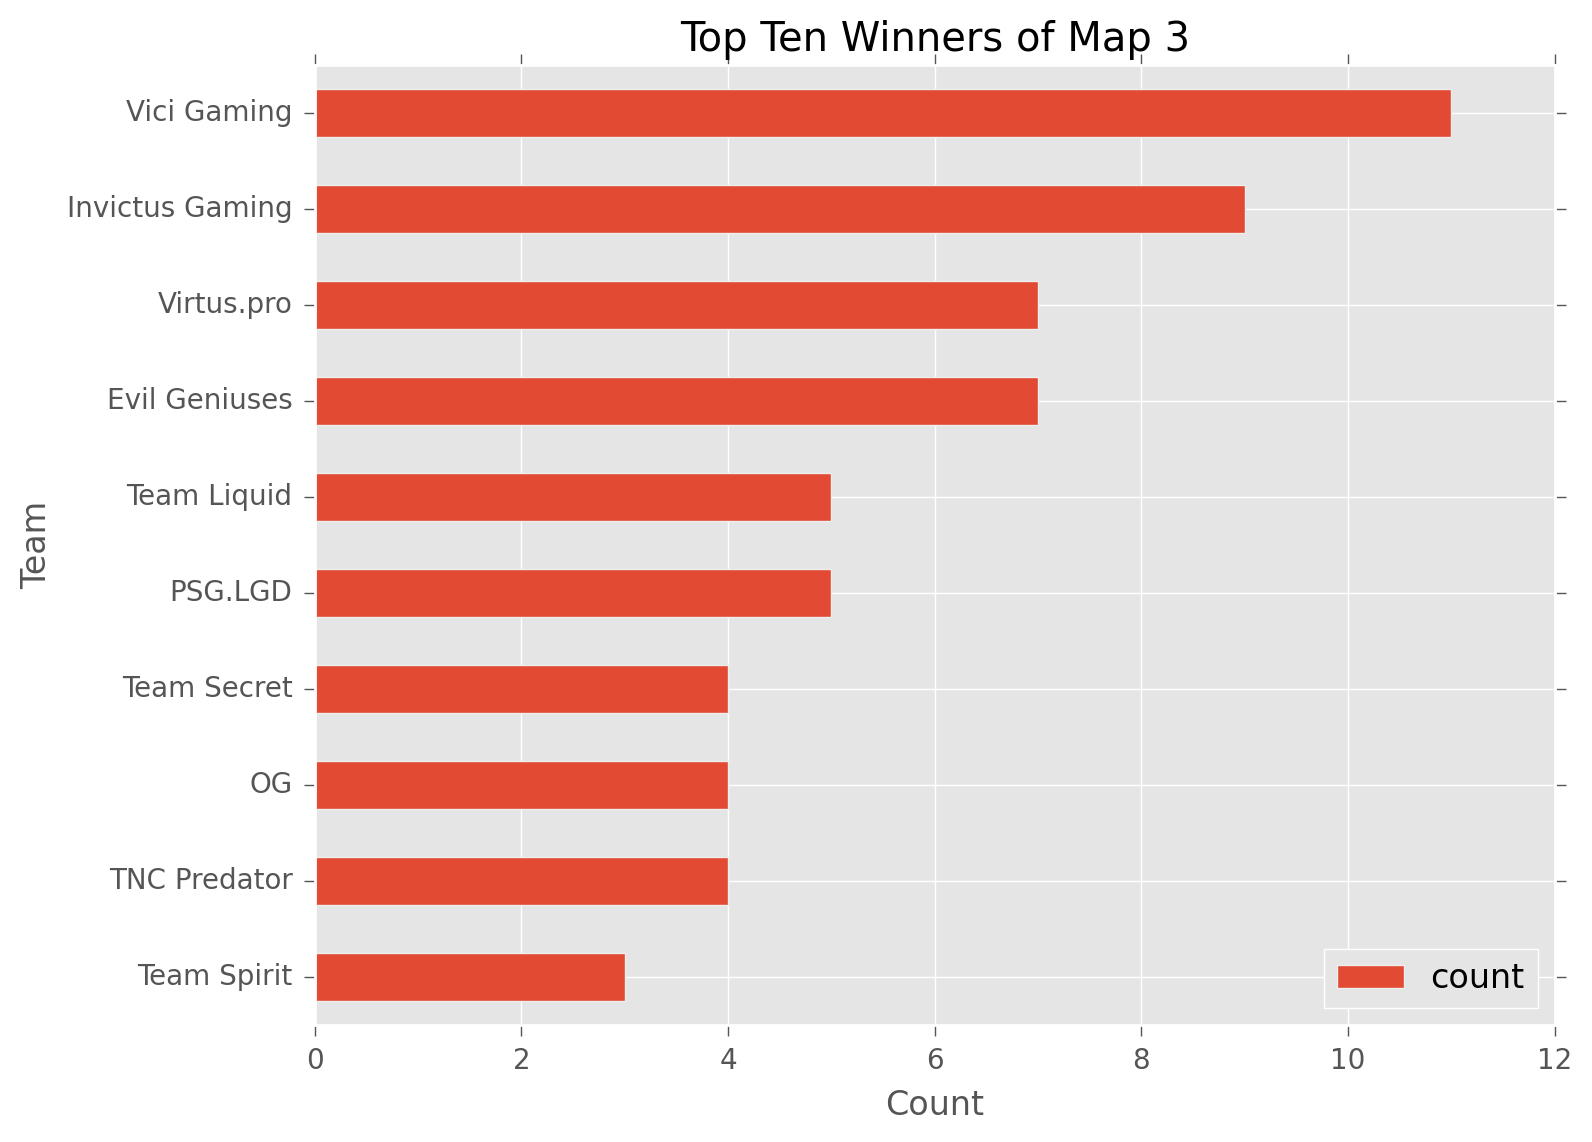

In [ ]:
# Convert to Pandas DataFrame
top_ten_winners_pd = top_ten_winners.toPandas()

# Plot the top ten most occurred winners as a horizontal bar plot
plt.figure(figsize=(10,6))
top_ten_winners_pd.sort_values('count').plot(kind='barh', x='TEAM', y='count')
plt.title('Top Ten Winners of Map 3')
plt.xlabel('Count')
plt.ylabel('Team')
plt.show()


In [ ]:
# Convert 'DURATION' from seconds to minutes
df0 = df0.withColumn('DURATION', df0['DURATION'] / 60)

# Filter the DataFrame to include only rows where 'DURATION' is greater than 60 and 'WIN' is 1
long_matches = df0.filter((df0['DURATION'] > 60) & (df0['WIN'] == 1))

# Count the occurrence of each winner
winner_counts = long_matches.groupBy('TEAM').count()

# Take only the top ten most occurred winners
top_ten_winners = winner_counts.orderBy('count', ascending=False).limit(10)

# Show the top ten most occurred winners
top_ten_winners.show()


+---------------+-----+
|           TEAM|count|
+---------------+-----+
|    Team Liquid|    6|
|   TNC Predator|    5|
|Invictus Gaming|    3|
|    Team Secret|    3|
|     Team Aster|    3|
|         Fnatic|    2|
|  Evil Geniuses|    2|
|   Nigma Galaxy|    1|
|      Outsiders|    1|
|        Undying|    1|
+---------------+-----+



<Figure size 2000x1200 with 0 Axes>

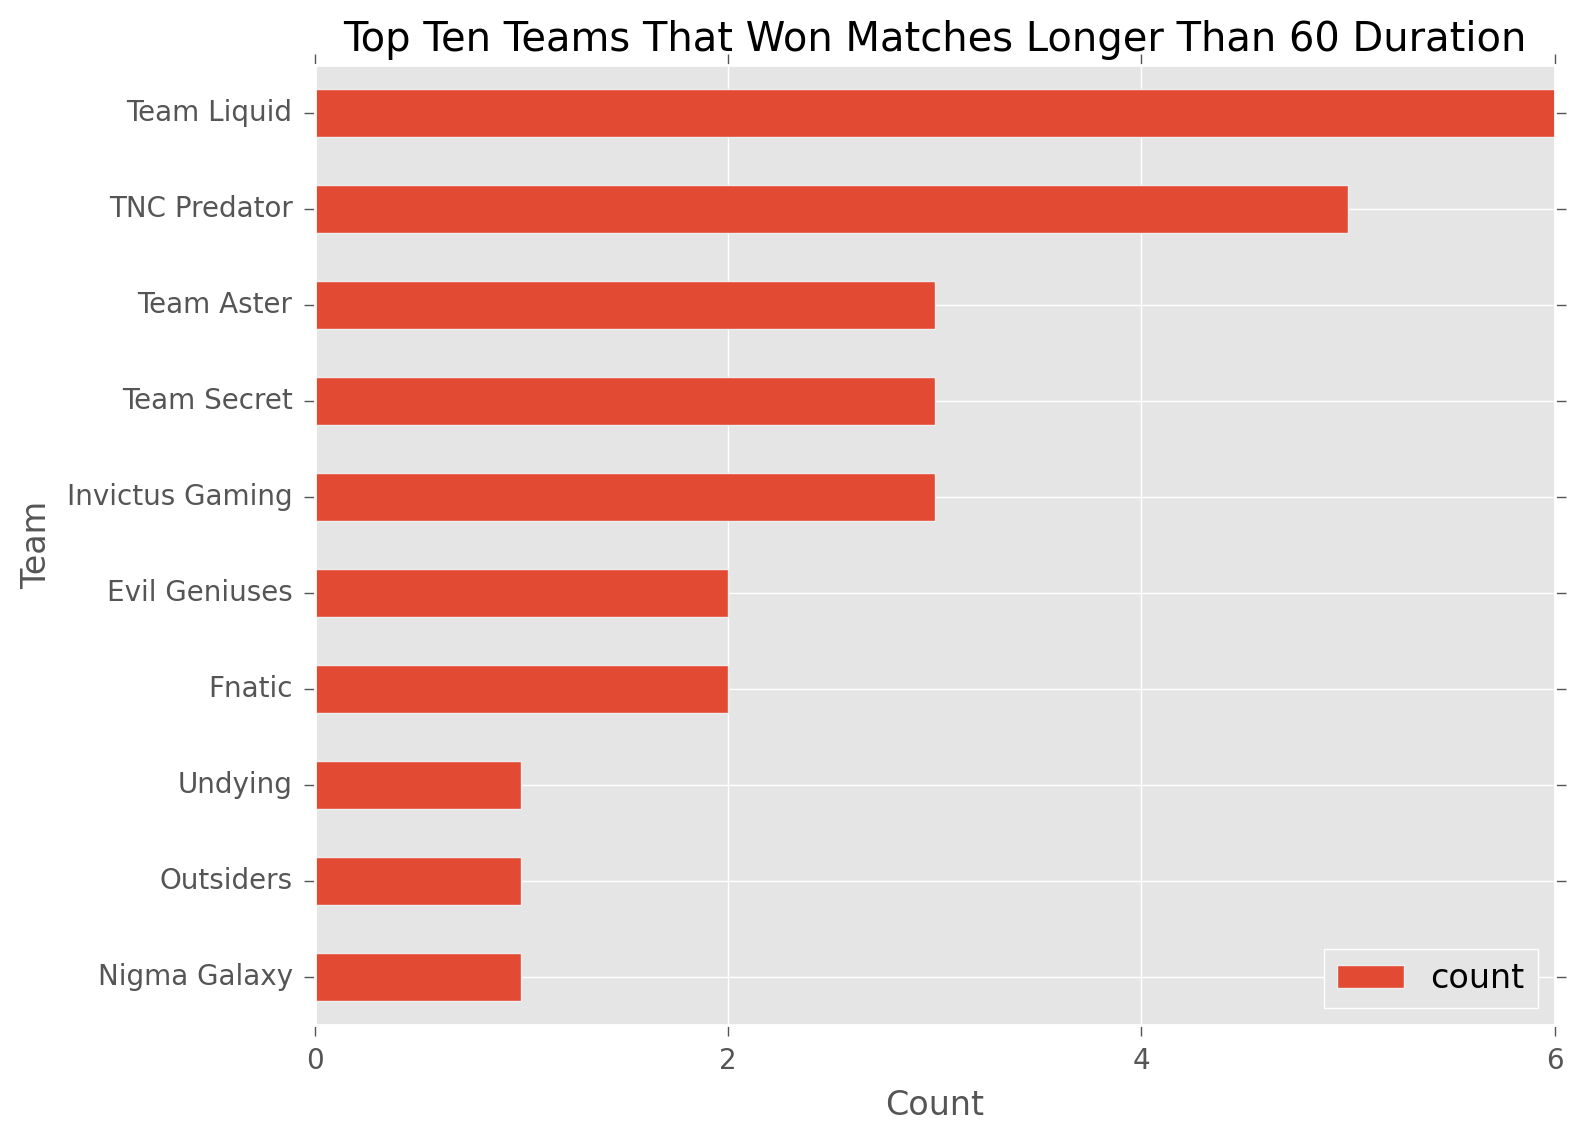

In [ ]:

# Convert to Pandas DataFrame
top_ten_winners_pd = top_ten_winners.toPandas()

# Plot the top ten most occurred winners as a horizontal bar plot
plt.figure(figsize=(10,6))
top_ten_winners_pd.sort_values('count').plot(kind='barh', x='TEAM', y='count')
plt.title('Top Ten Teams That Won Matches Longer Than 60 Duration')
plt.xlabel('Count')
plt.ylabel('Team')

# Adjust x-axis ticks
plt.xticks(np.arange(0, top_ten_winners_pd['count'].max() + 1, 2))

plt.show()


In [ ]:
# Calculate the total duration for each tournament
tournament_durations = df0.groupBy('TOURNAMENT').agg(F.sum('DURATION').alias('Total Duration'))

# Take only the top ten tournaments with the most total duration
top_ten_tournaments = tournament_durations.orderBy('Total Duration', ascending=False).limit(10)

# Show the top ten tournaments
top_ten_tournaments.show()


+--------------------+------------------+
|          TOURNAMENT|    Total Duration|
+--------------------+------------------+
|The International...|  9258.56666666667|
|The International...| 7831.283333333333|
|The International...| 7590.916666666668|
|PGL Arlington Maj...| 6664.600000000002|
|WePlay AniMajor 2021| 5099.150000000002|
|ONE Esports Singa...| 4983.966666666666|
|ESL One Stockholm...| 4818.783333333335|
|The Leipzig Major...|3901.0333333333324|
|MDL Chengdu Major...|3854.3166666666657|
|Epicenter Major 2019| 3776.549999999999|
+--------------------+------------------+



<Figure size 2000x1200 with 0 Axes>

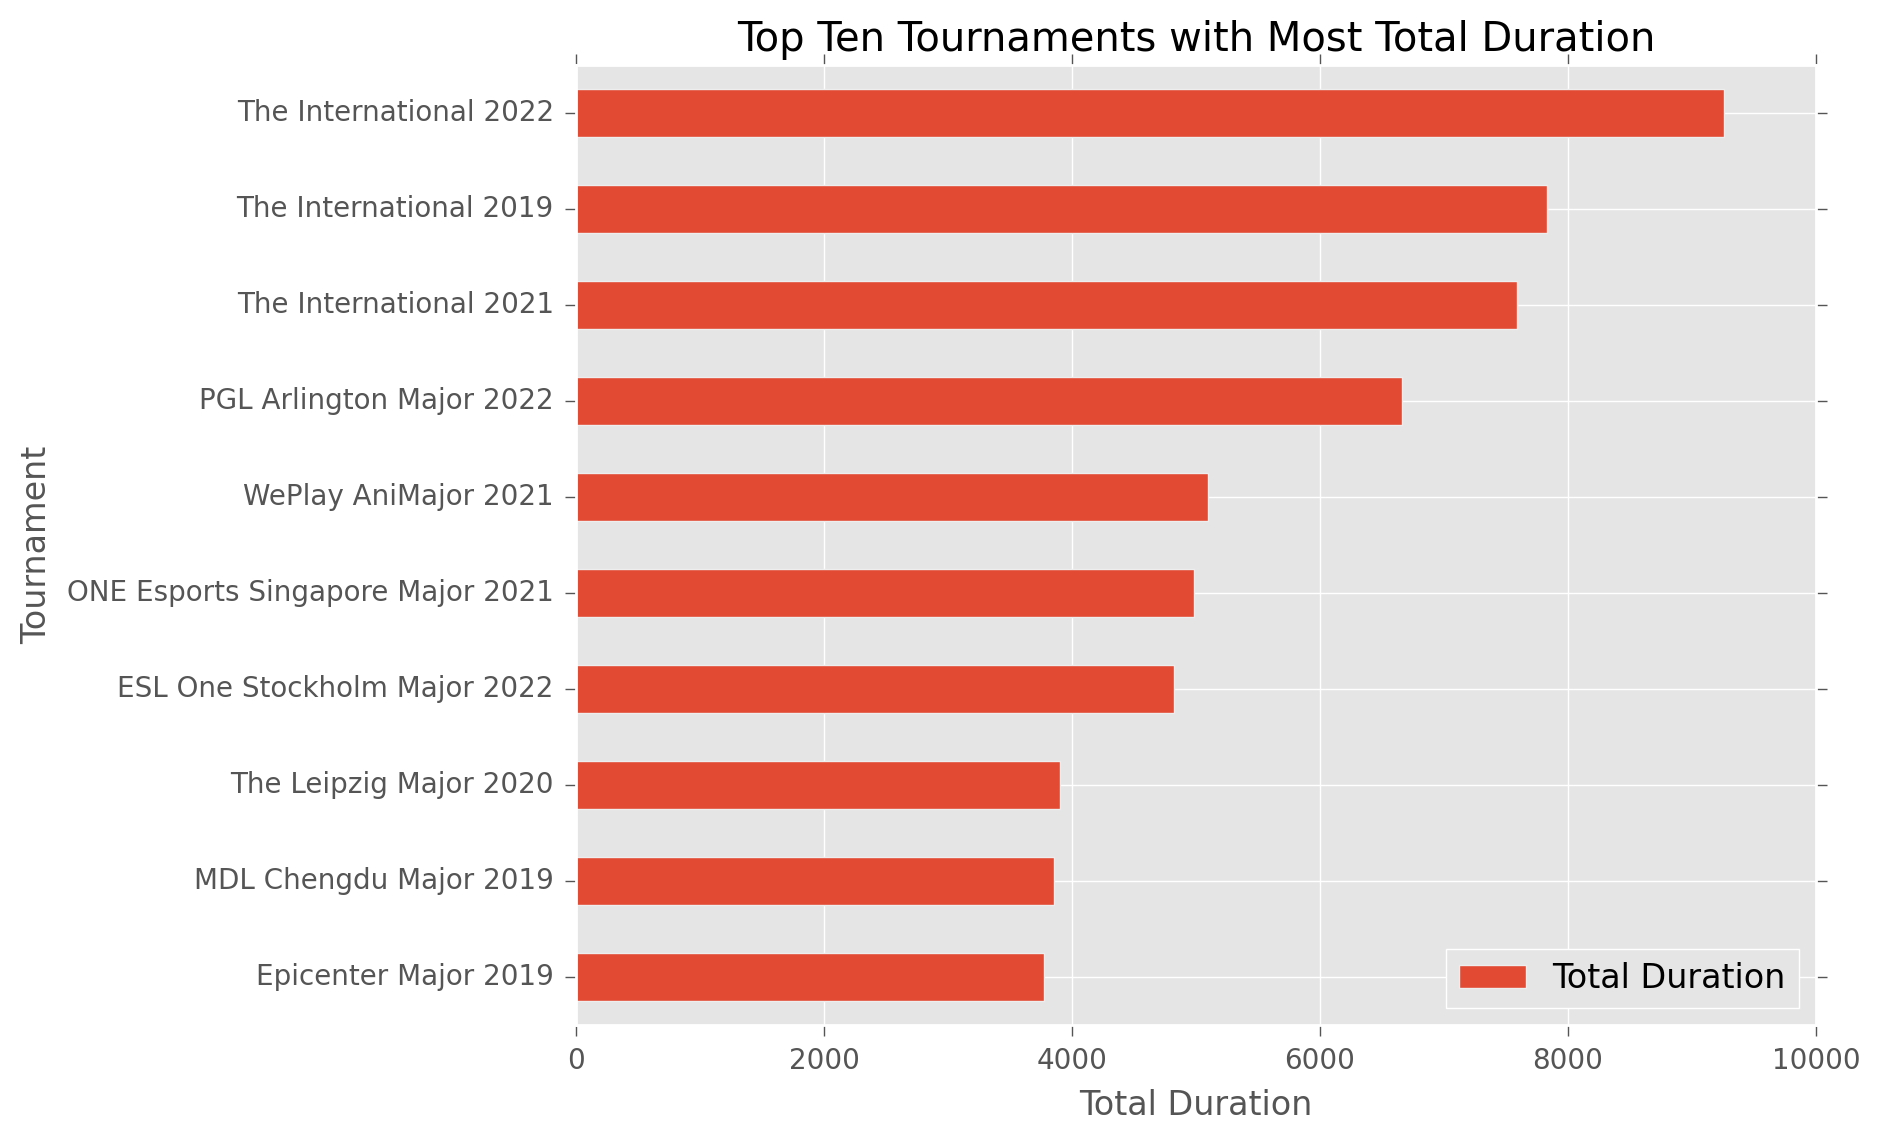

In [ ]:
# Convert to Pandas DataFrame
top_ten_tournaments_pd = top_ten_tournaments.toPandas()

# Plot the top ten tournaments as a horizontal bar plot
plt.figure(figsize=(10,6))
top_ten_tournaments_pd.sort_values('Total Duration').plot(kind='barh', x='TOURNAMENT', y='Total Duration')
plt.title('Top Ten Tournaments with Most Total Duration')
plt.xlabel('Total Duration')
plt.ylabel('Tournament')
plt.show()


In [ ]:

# Split the 'Score' column into two columns 'Team1_Score' and 'Team2_Score'
split_col = F.split(df0['Score'], '-')
df0 = df0.withColumn('Team1_Score', split_col.getItem(0).cast(IntegerType()))
df0 = df0.withColumn('Team2_Score', split_col.getItem(1).cast(IntegerType()))

# Calculate the absolute difference and sum of the scores
df0 = df0.withColumn('Score_Difference', F.abs(df0['Team1_Score'] - df0['Team2_Score']))
df0 = df0.withColumn('Score_Sum', df0['Team1_Score'] + df0['Team2_Score'])

# Filter matches where the duration is more than 45
df0 = df0.filter(df0['DURATION'] > 45)

# Sort the dataframe first by 'Score_Difference' and then by 'Score_Sum'
df0 = df0.orderBy(['Score_Difference', 'Score_Sum'], ascending=[True, False])

# Get the top 10 matches
top_10_matches = df0.limit(10)

# Show the top 10 matches
top_10_matches.show()


+-------+-------+--------+--------------------+---+--------------+-----+------------------+----+------------------+-----+---+------+-------------+----------------+--------------+-----------+------------------+--------------------+--------------------+--------------------+-----------+-----------+----------------+---------+
|     ID|   SIDE|MATCH_ID|          TOURNAMENT|MAP|          TEAM|Score|          DURATION|PICK|              HERO|PRIZE|Win|RESULT|       HERO_1|          HERO_2|        HERO_3|     HERO_4|            HERO_5|               DRAFT|               Match|               Teams|Team1_Score|Team2_Score|Score_Difference|Score_Sum|
+-------+-------+--------+--------------------+---+--------------+-----+------------------+----+------------------+-----+---+------+-------------+----------------+--------------+-----------+------------------+--------------------+--------------------+--------------------+-----------+-----------+----------------+---------+
|313-1-R|radiant|   313-1|Th

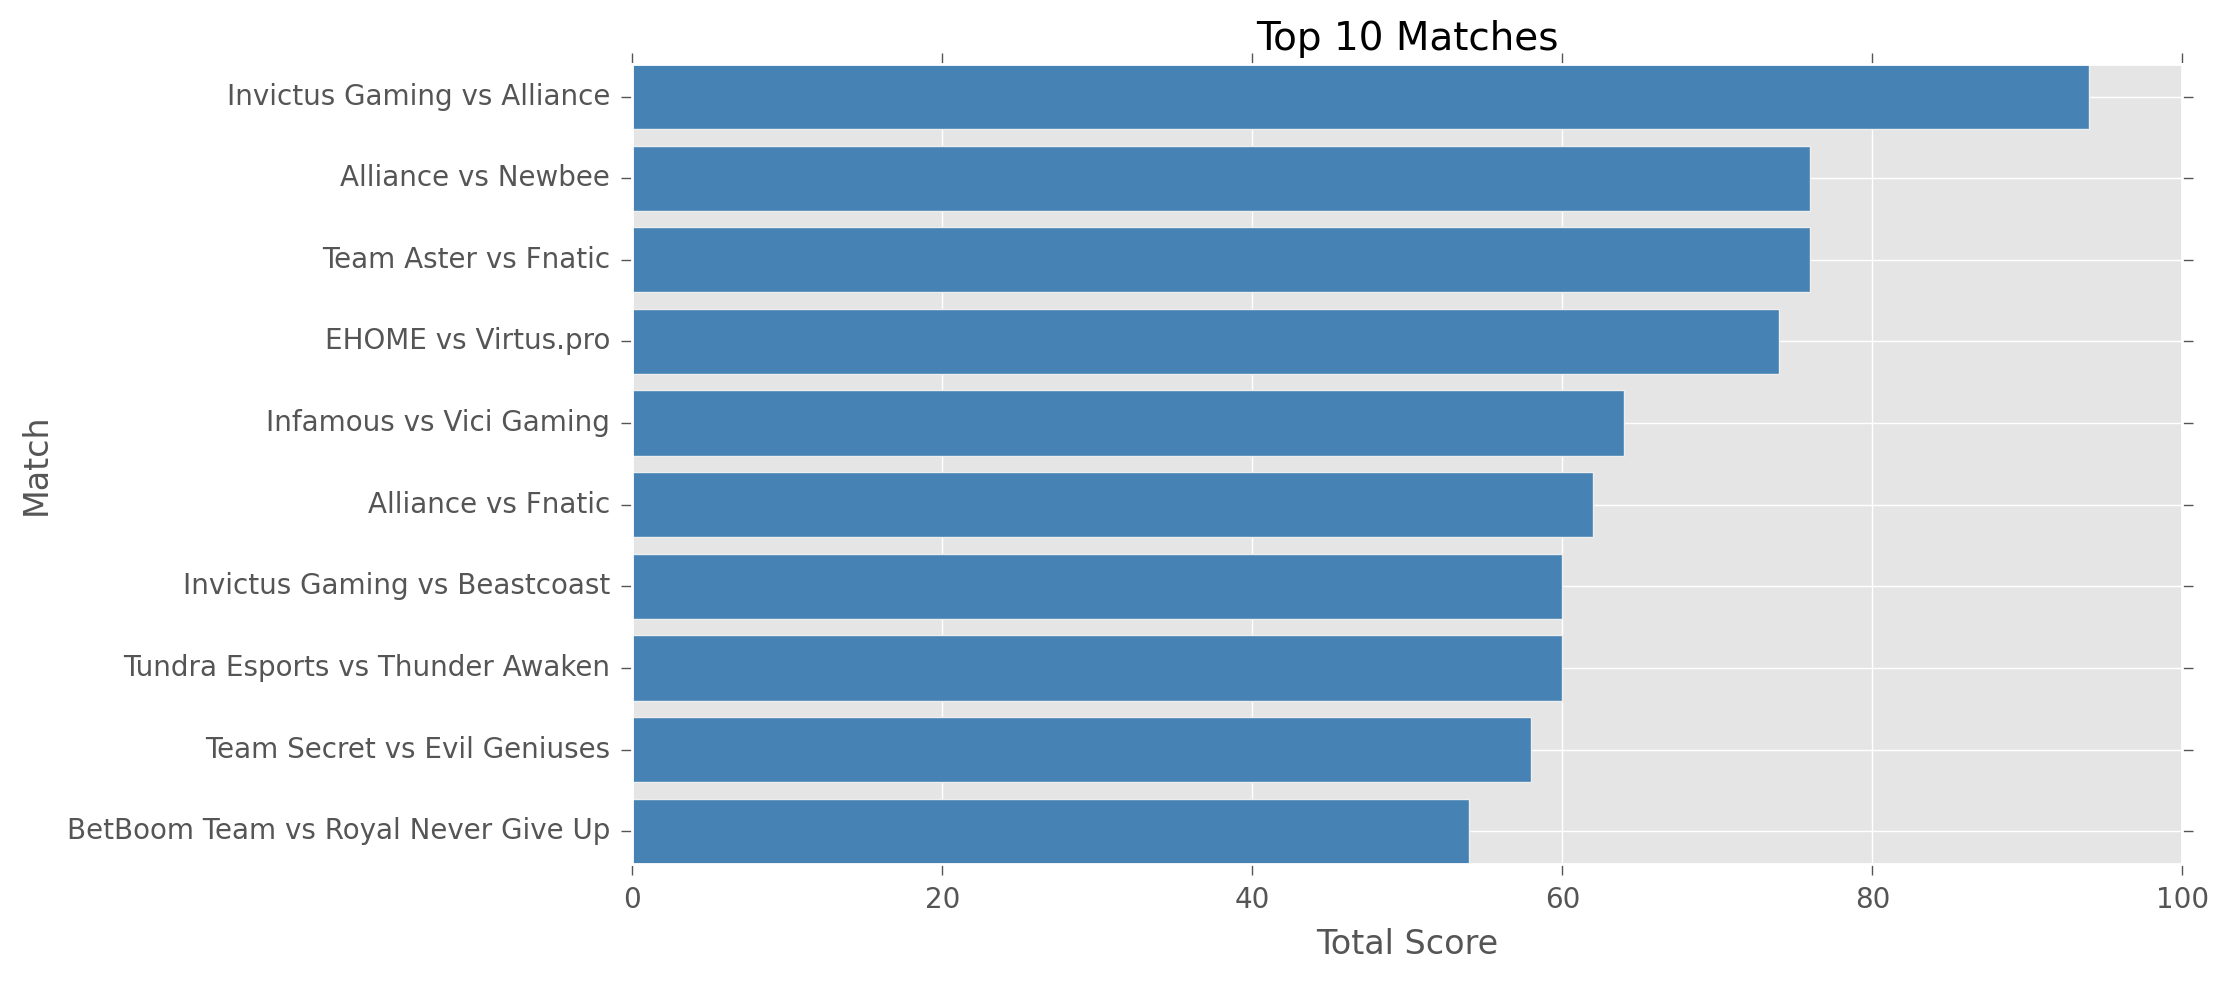

In [ ]:
# Convert to Pandas DataFrame
top_10_matches_pd = top_10_matches.toPandas()

# Plot the top 10 matches
plt.figure(figsize=(10, 5))
plt.barh(top_10_matches_pd['Match'], top_10_matches_pd['Score_Sum'], color='steelblue')
plt.xlabel('Total Score', fontsize=12)
plt.ylabel('Match', fontsize=12)
plt.title('Top 10 Matches', fontsize=14)
plt.gca().invert_yaxis()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


In [ ]:

# Let's name the DataFrame 'games'
games = df0

# Split the 'Score' column into two columns 'Team1_Score' and 'Team2_Score'
split_col = F.split(games['Score'], '-')
games = games.withColumn('Team1_Score', split_col.getItem(0).cast(IntegerType()))
games = games.withColumn('Team2_Score', split_col.getItem(1).cast(IntegerType()))

# Calculate the absolute difference and sum of the scores
games = games.withColumn('Score_Difference', F.abs(games['Team1_Score'] - games['Team2_Score']))
games = games.withColumn('Score_Sum', games['Team1_Score'] + games['Team2_Score'])

# Sort the dataframe by 'Score_Difference' in descending order
games = games.orderBy('Score_Difference', ascending=False)

# Get the top 10 matches
top_10_games = games.limit(10)

# Show the top 10 matches
top_10_games.show()


+-------+-------+--------+--------------------+---+-------------+-----+------------------+----+----------------+-----+---+------+------------+-------------+------------+-------------+----------------+--------------------+--------------------+--------------------+-----------+-----------+----------------+---------+
|     ID|   SIDE|MATCH_ID|          TOURNAMENT|MAP|         TEAM|Score|          DURATION|PICK|            HERO|PRIZE|Win|RESULT|      HERO_1|       HERO_2|      HERO_3|       HERO_4|          HERO_5|               DRAFT|               Match|               Teams|Team1_Score|Team2_Score|Score_Difference|Score_Sum|
+-------+-------+--------+--------------------+---+-------------+-----+------------------+----+----------------+-----+---+------+------------+-------------+------------+-------------+----------------+--------------------+--------------------+--------------------+-----------+-----------+----------------+---------+
|280-3-R|radiant|   280-3|MDL Chengdu Major...|  3|   B

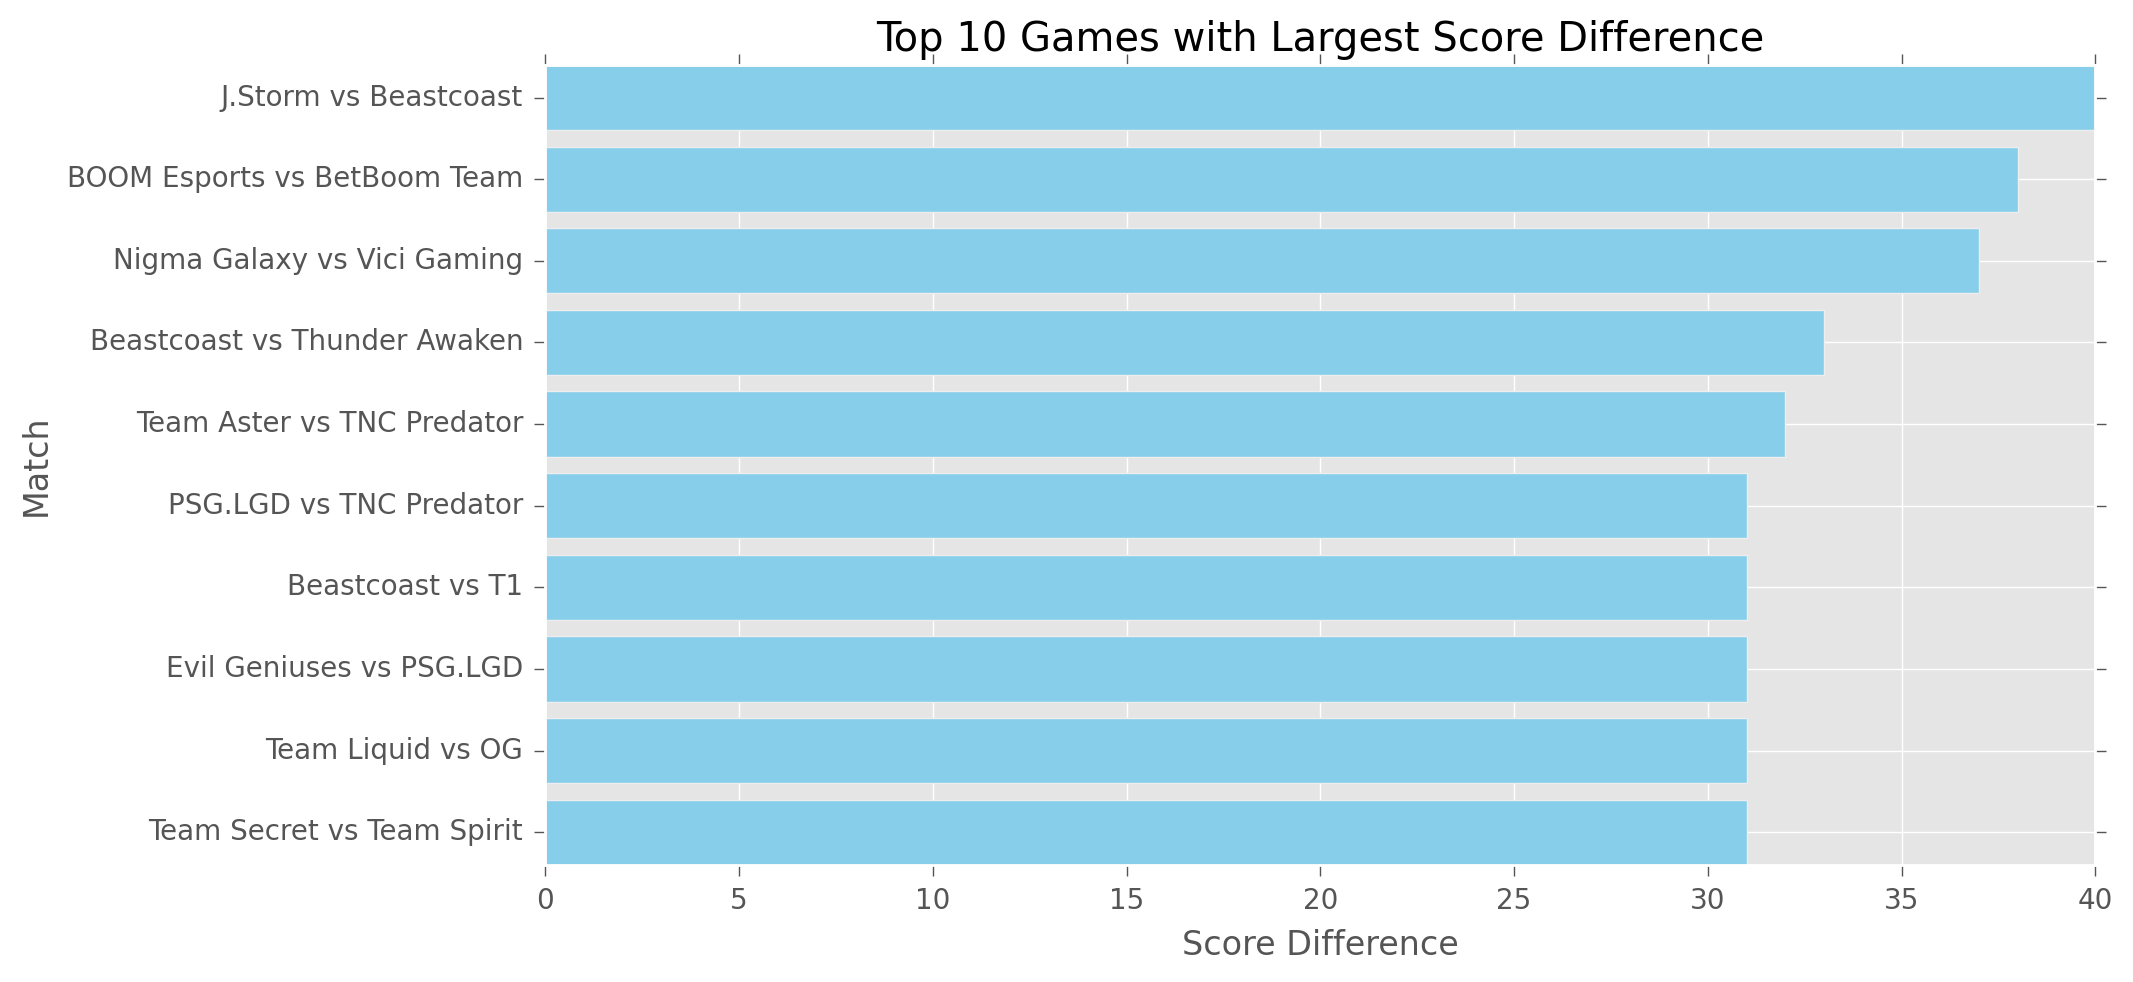

In [ ]:
# Convert to Pandas DataFrame
top_10_games_pd = top_10_games.toPandas()

# Plot the top 10 matches
plt.figure(figsize=(10, 5))
plt.barh(top_10_games_pd['Match'], top_10_games_pd['Score_Difference'], color='skyblue')
plt.xlabel('Score Difference')
plt.ylabel('Match')
plt.title('Top 10 Games with Largest Score Difference')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# Explode the 'DRAFT' column into multiple rows, each containing one hero
exploded_df = df.select('*', F.explode(df['DRAFT']).alias('Hero__'))

# Count the number of times each hero is picked
hero_counts = exploded_df.groupBy('Hero__').count()

# Get the top 10 most picked heroes
top_10_heroes = hero_counts.orderBy('count', ascending=False).limit(10)

# Get the 10 least picked heroes
bottom_10_heroes = hero_counts.orderBy('count', ascending=True).limit(10)

# Show the top 10 and bottom 10 heroes
top_10_heroes.show()
bottom_10_heroes.show()


+------------+-----+
|      Hero__|count|
+------------+-----+
|        Tiny|  475|
|        Puck|  331|
|     Leshrac|  300|
|        Mars|  280|
|Ember Spirit|  280|
|   Pangolier|  274|
|      Rubick|  268|
| Elder Titan|  247|
|  Grimstroke|  246|
| Earthshaker|  241|
+------------+-----+

+--------------+-----+
|        Hero__|count|
+--------------+-----+
|       Techies|    6|
|          Riki|    9|
|         Meepo|   16|
|        Clinkz|   20|
| Bounty Hunter|   23|
|        Tinker|   27|
|        Huskar|   28|
|Spirit Breaker|   45|
|    Arc Warden|   46|
|        Sniper|   57|
+--------------+-----+



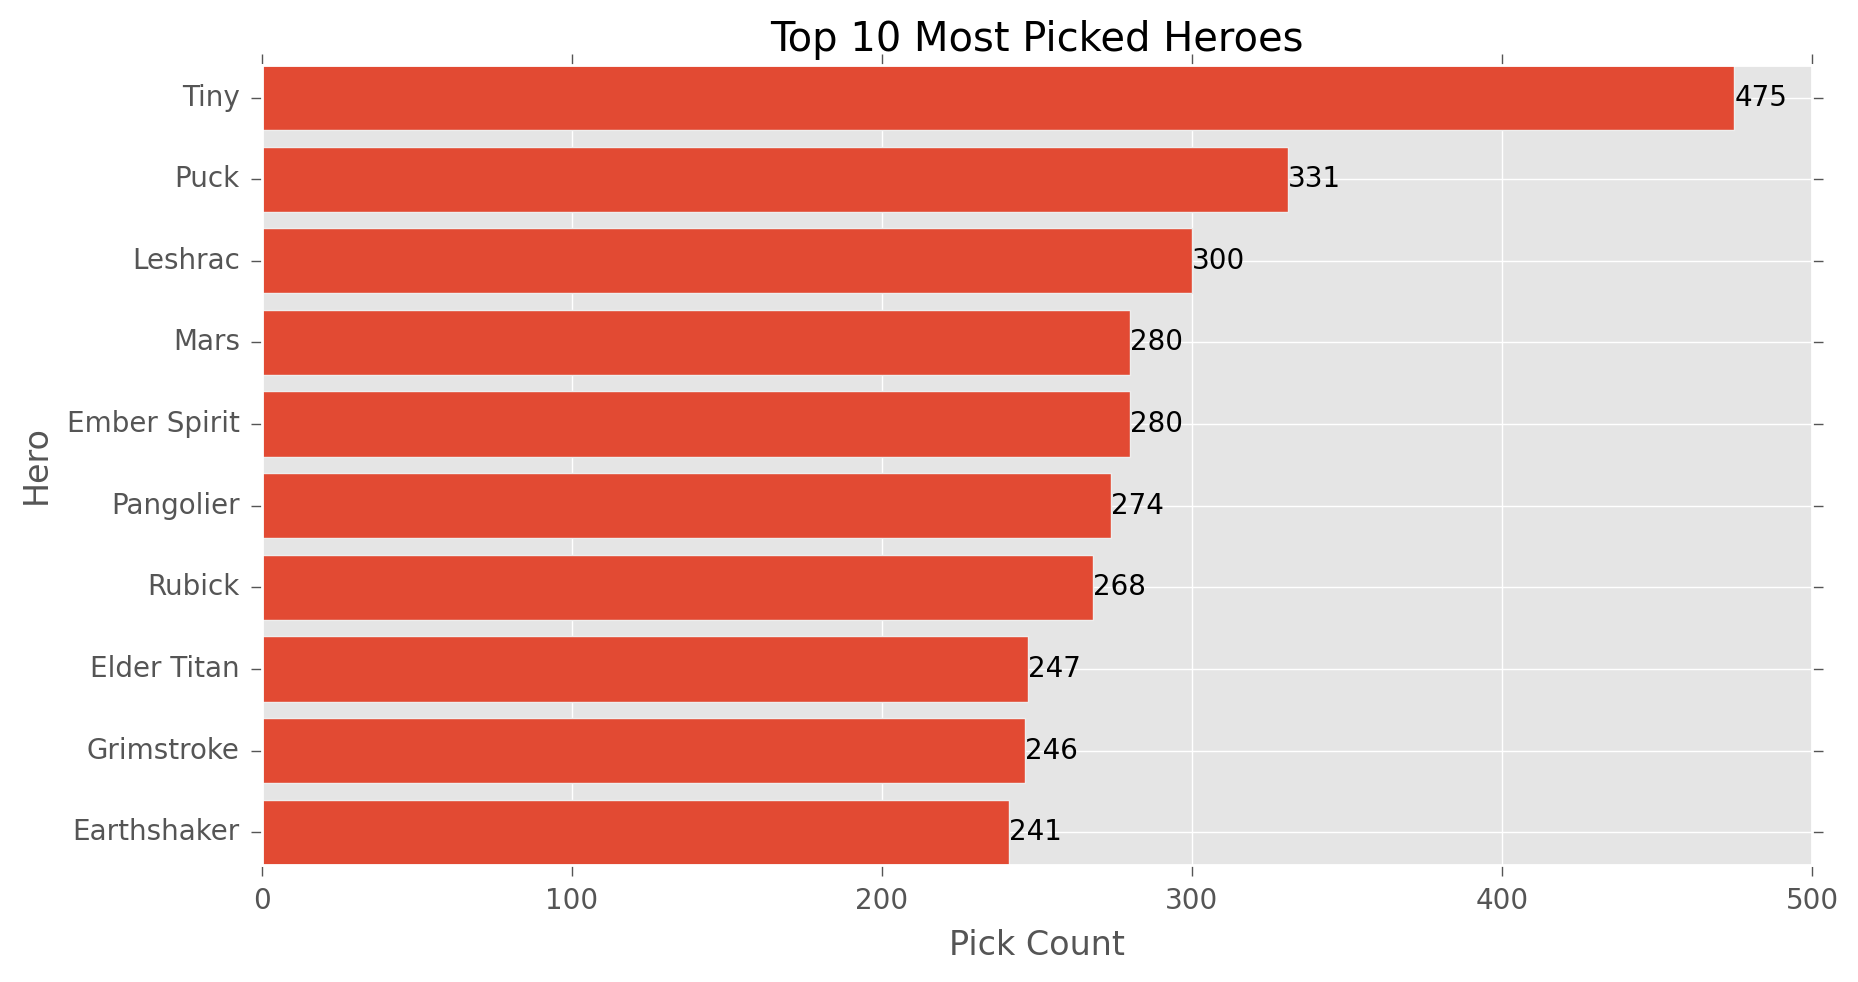

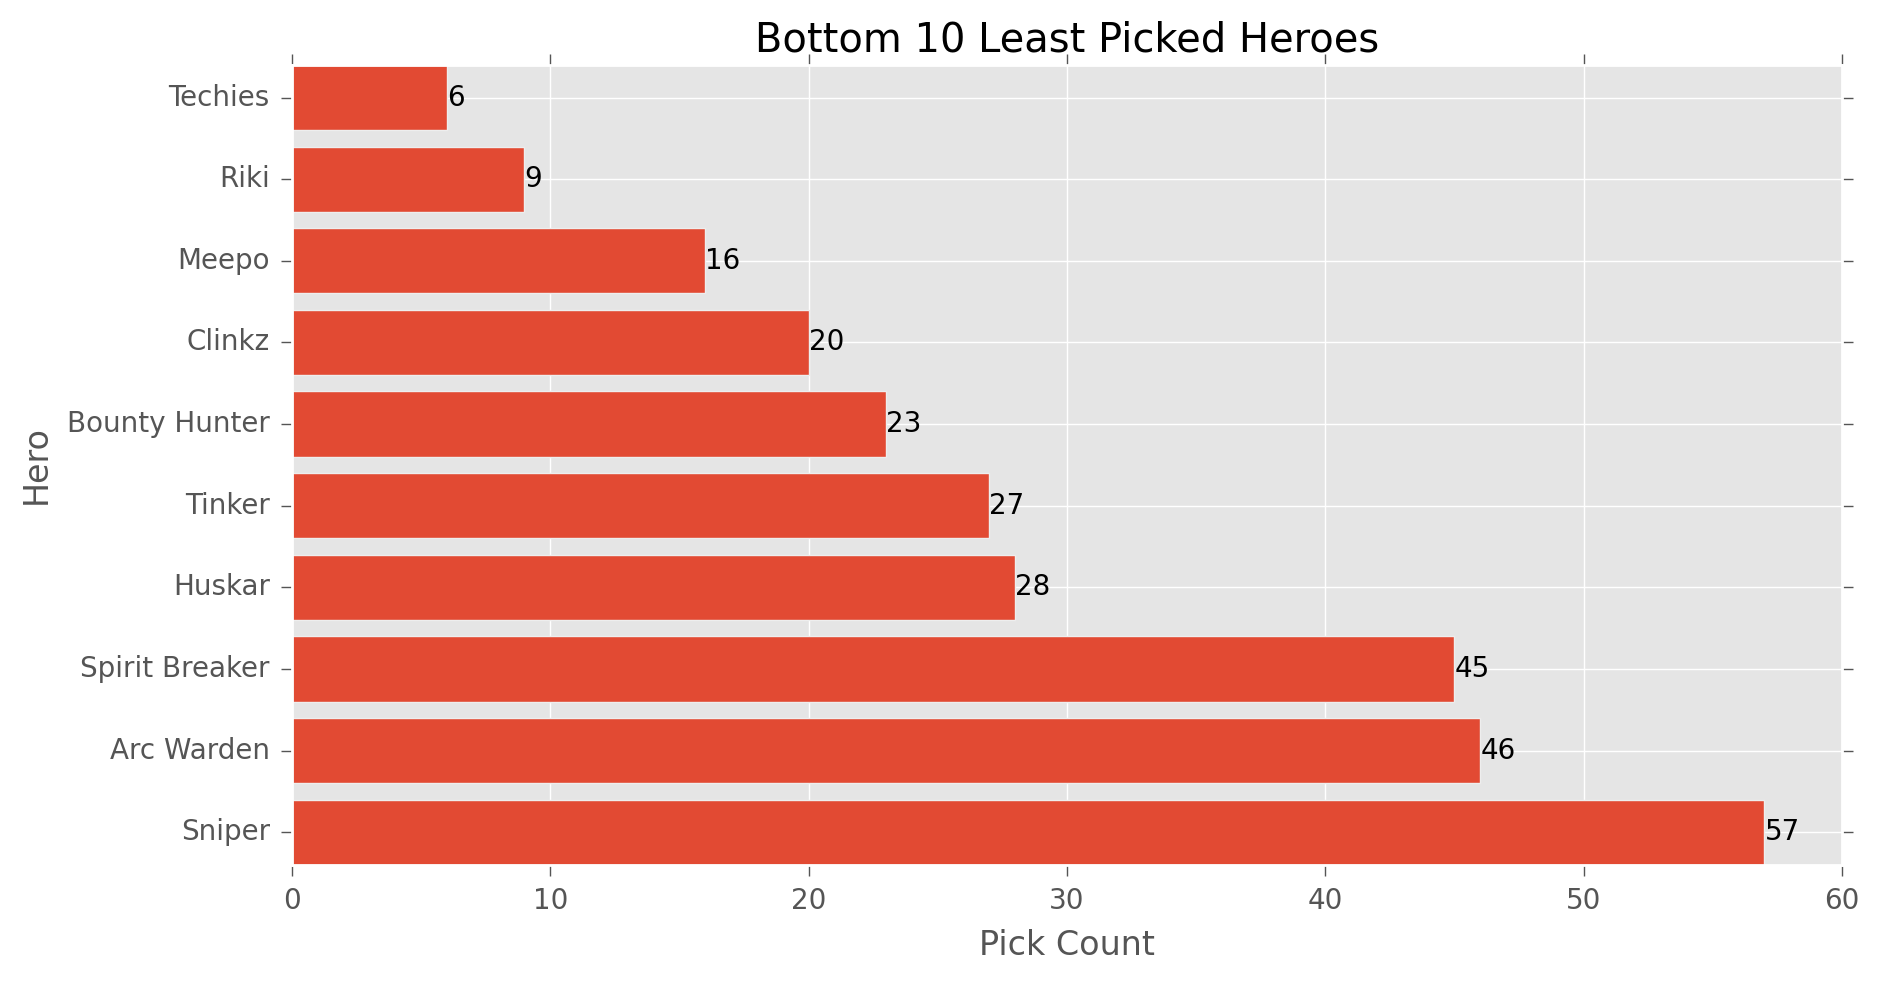

In [ ]:

# Convert to Pandas DataFrame
top_10_heroes_pd = top_10_heroes.toPandas()
bottom_10_heroes_pd = bottom_10_heroes.toPandas()

# Plot the top 10 heroes
plt.figure(figsize=(10,5))
bars = plt.barh(top_10_heroes_pd['Hero__'], top_10_heroes_pd['count'])
plt.title('Top 10 Most Picked Heroes')
plt.xlabel('Pick Count')
plt.ylabel('Hero')

# Add text over each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width()}', va='center')

plt.gca().invert_yaxis()  # Invert the y-axis to have the hero with the highest count at the top
plt.show()

# Plot the bottom 10 heroes
plt.figure(figsize=(10,5))
bars = plt.barh(bottom_10_heroes_pd['Hero__'], bottom_10_heroes_pd['count'])
plt.title('Bottom 10 Least Picked Heroes')
plt.xlabel('Pick Count')
plt.ylabel('Hero')

# Add text over each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width()}', va='center')

plt.gca().invert_yaxis()  # Invert the y-axis to have the hero with the lowest count at the top
plt.show()
